<a href="https://www.kaggle.com/code/dataranch/ssh-logs-model-comparison-more?scriptVersionId=106919671" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**SSH Attack Dataset Baseline Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.
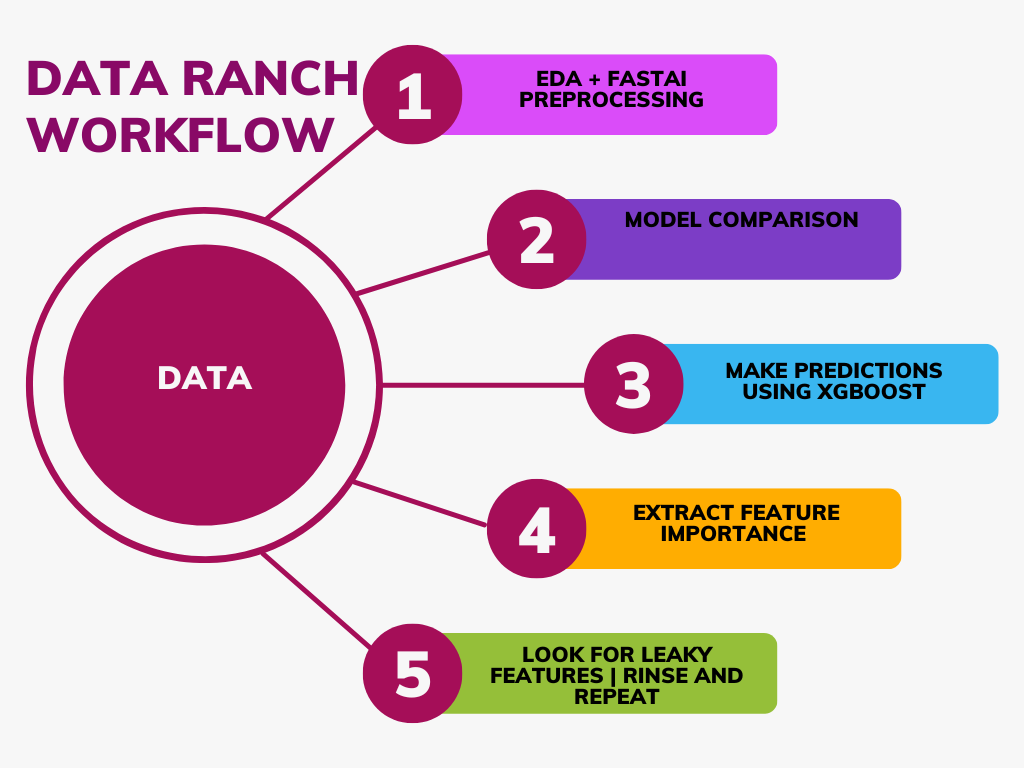

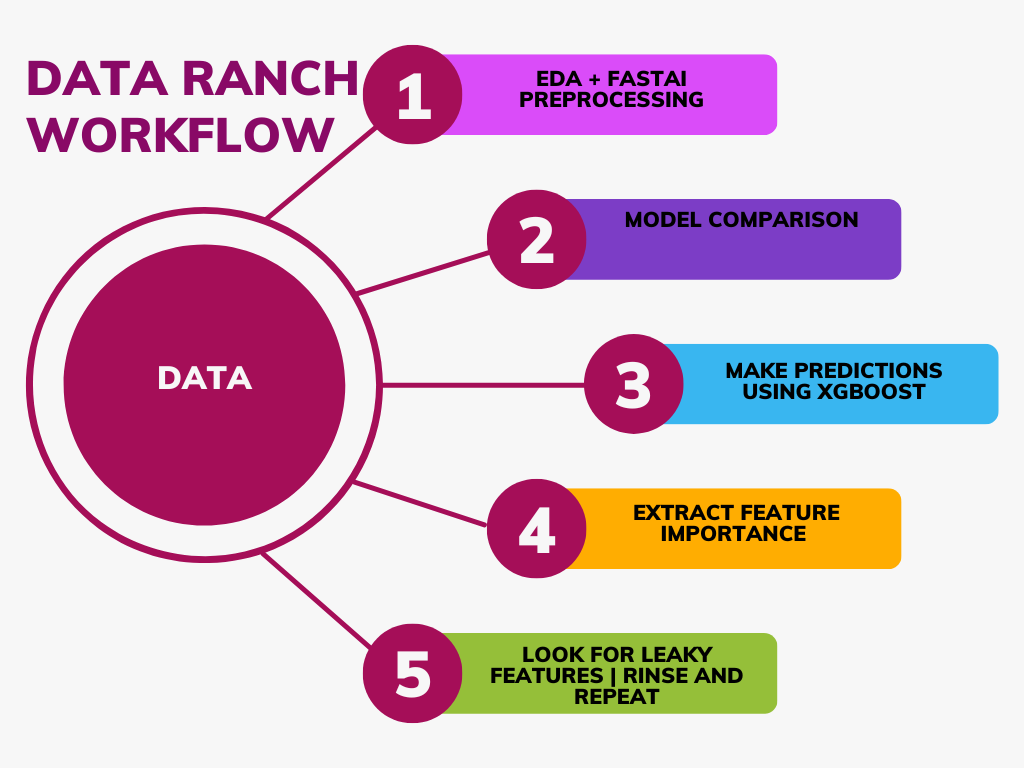

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'ssh-logs-with-attack-classification'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [10]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/ssh-logs-with-attack-classification
CSV!


In [11]:
df

,user,is_private,is_failure,is_root,is_valid,not_valid_count,ip_failure,ip_success,no_failure,first,td,ts,class
0,kamran,1,1,0,1,0,1,0,2,1,0,1544678520.00,0
1,kamran,1,1,0,1,0,2,0,3,0,18,1544678538.00,0
2,student,1,0,0,1,0,0,1,0,0,133,1544678671.00,0
3,kamran,1,1,0,1,0,1,1,2,0,58,1544678729.00,0
4,kamran,1,1,0,1,0,2,1,3,0,29,1544678758.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,osamac,1,1,0,1,0,8,0,12,0,21,1514930577.00,1
279,osamac,1,1,0,1,0,9,0,13,0,16,1514930593.00,1
280,osamac,1,0,0,1,0,0,1,0,0,7,1514930600.00,0
281,osamac,1,0,0,1,0,0,1,0,1,0,1514959406.00,0


In [12]:
df.isna().sum()

user               0
is_private         0
is_failure         0
is_root            0
is_valid           0
not_valid_count    0
ip_failure         0
ip_success         0
no_failure         0
first              0
td                 0
ts                 0
class              0
dtype: int64

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

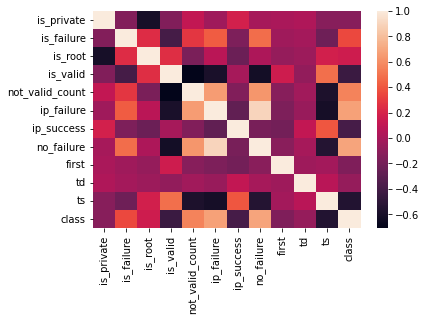

In [14]:
sns.heatmap(df.corr())

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,user,is_private,is_failure,is_root,is_valid,not_valid_count,ip_failure,ip_success,no_failure,first,td,ts,class
0,kamran,1,1,0,1,0,1,0,2,1,0,1544678520.00,0
1,kamran,1,1,0,1,0,2,0,3,0,18,1544678538.00,0
2,student,1,0,0,1,0,0,1,0,0,133,1544678671.00,0
3,kamran,1,1,0,1,0,1,1,2,0,58,1544678729.00,0
4,kamran,1,1,0,1,0,2,1,3,0,29,1544678758.00,0


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
is_private,283.00,0.95,0.22,0.00,1.00,1.00,1.00,1.00
is_failure,283.00,0.72,0.45,0.00,0.00,1.00,1.00,1.00
is_root,283.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00
is_valid,283.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
not_valid_count,283.00,2.71,5.93,0.00,0.00,0.00,2.00,30.00
ip_failure,283.00,6.41,9.64,0.00,0.00,2.00,8.00,45.00
ip_success,283.00,7.09,9.37,0.00,0.00,2.00,14.00,33.00
no_failure,283.00,7.62,9.99,0.00,0.00,4.00,11.00,45.00
first,283.00,0.07,0.26,0.00,0.00,0.00,0.00,1.00
td,283.00,3144.92,24323.83,0.00,4.00,13.00,70.50,322997.00


In [17]:
df.columns

Index(['user', 'is_private', 'is_failure', 'is_root', 'is_valid',
       'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'first',
       'td', 'ts', 'class'],
      dtype='object')

Target Variable: class
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
13
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 282


 14%|█▍        | 6/42 [00:00<00:00, 57.16it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.2653797579472923, 'Adjusted R-Squared': 0.19191773374202148, 'RMSE': 0.39409432647979936, 'Time taken': 0.016446590423583984}
{'Model': 'BaggingRegressor', 'R-Squared': 0.25720857926680774, 'Adjusted R-Squared': 0.18292943719348842, 'RMSE': 0.396280020408109, 'Time taken': 0.026477336883544922}
{'Model': 'BayesianRidge', 'R-Squared': 0.26119612741755116, 'Adjusted R-Squared': 0.1873157401593062, 'RMSE': 0.3952149084070849, 'Time taken': 0.028879404067993164}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.2584211470636596, 'Adjusted R-Squared': 0.1842632617700255, 'RMSE': 0.39595643518451445, 'Time taken': 0.010219335556030273}
{'Model': 'DummyRegressor', 'R-Squared': -0.035601989972178893, 'Adjusted R-Squared': -0.1391621889693968, 'RMSE': 0.4679130689554928, 'Time taken': 0.00969076156616211}
{'Model': 'ElasticNet', 'R-Squared': -0.035601989972178893, 'Adjusted R-Squared': -0.1391621889693968, 'RMSE': 0.4679130689554928, 'Time taken': 0

 29%|██▊       | 12/42 [00:00<00:01, 26.52it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.2621127475676528, 'Adjusted R-Squared': 0.18832402232441803, 'RMSE': 0.39496966444263215, 'Time taken': 0.07671546936035156}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2555955523297291, 'Adjusted R-Squared': 0.18115510756270192, 'RMSE': 0.3967100628687284, 'Time taken': 0.11726880073547363}
{'Model': 'HuberRegressor', 'R-Squared': -0.0980156783033681, 'Adjusted R-Squared': -0.2078172461337051, 'RMSE': 0.48180689178117386, 'Time taken': 0.0632164478302002}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.030467571644042568, 'Adjusted R-Squared': -0.13351432880844682, 'RMSE': 0.46675169293441554, 'Time taken': 0.010437488555908203}


 38%|███▊      | 16/42 [00:00<00:01, 22.11it/s]

{'Model': 'KernelRidge', 'R-Squared': -7.499947617685624, 'Adjusted R-Squared': -8.349942379454188, 'RMSE': 1.3405310008820217, 'Time taken': 0.04033470153808594}
{'Model': 'Lars', 'R-Squared': 0.2614166113737675, 'Adjusted R-Squared': 0.1875582725111442, 'RMSE': 0.39515593128742244, 'Time taken': 0.04413032531738281}


 45%|████▌     | 19/42 [00:00<00:01, 22.51it/s]

{'Model': 'LarsCV', 'R-Squared': 0.2609126339767047, 'Adjusted R-Squared': 0.18700389737437517, 'RMSE': 0.3952907269649015, 'Time taken': 0.06729531288146973}
{'Model': 'Lasso', 'R-Squared': -0.035601989972178893, 'Adjusted R-Squared': -0.1391621889693968, 'RMSE': 0.4679130689554928, 'Time taken': 0.013057947158813477}
{'Model': 'LassoCV', 'R-Squared': 0.2609654569645907, 'Adjusted R-Squared': 0.18706200266104978, 'RMSE': 0.3952766008877019, 'Time taken': 0.06023764610290527}
{'Model': 'LassoLars', 'R-Squared': -0.035601989972178893, 'Adjusted R-Squared': -0.1391621889693968, 'RMSE': 0.4679130689554928, 'Time taken': 0.0098724365234375}


 55%|█████▍    | 23/42 [00:00<00:00, 26.30it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.2609126339767047, 'Adjusted R-Squared': 0.18700389737437517, 'RMSE': 0.3952907269649015, 'Time taken': 0.01978445053100586}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2614166113737675, 'Adjusted R-Squared': 0.1875582725111442, 'RMSE': 0.39515593128742244, 'Time taken': 0.0117950439453125}
{'Model': 'LinearRegression', 'R-Squared': 0.2614166113737677, 'Adjusted R-Squared': 0.18755827251114443, 'RMSE': 0.3951559312874224, 'Time taken': 0.01107645034790039}
{'Model': 'LinearSVR', 'R-Squared': -0.09803921638238688, 'Adjusted R-Squared': -0.2078431380206256, 'RMSE': 0.4818120559824404, 'Time taken': 0.010263442993164062}


 64%|██████▍   | 27/42 [00:01<00:00, 21.04it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.2693936098263726, 'Adjusted R-Squared': 0.1963329708090098, 'RMSE': 0.39301621644906354, 'Time taken': 0.21648287773132324}
{'Model': 'NuSVR', 'R-Squared': -0.09785332847162764, 'Adjusted R-Squared': -0.2076386613187906, 'RMSE': 0.4817712710878762, 'Time taken': 0.02723526954650879}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2129463425359155, 'Adjusted R-Squared': 0.13424097678950697, 'RMSE': 0.40791615742153564, 'Time taken': 0.02228856086730957}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2408703897408041, 'Adjusted R-Squared': 0.1649574287148844, 'RMSE': 0.40061453574550804, 'Time taken': 0.030312061309814453}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.11799817219754827, 'Adjusted R-Squared': -0.22979798941730323, 'RMSE': 0.4861712622386414, 'Time taken': 0.022924184799194336}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2102859624325072, 'Adjusted R-Squared': 0.1313145586757578, 'RMSE': 0.40860499007825635

 76%|███████▌  | 32/42 [00:01<00:00, 12.25it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.43589743589697316, 'Adjusted R-Squared': -0.5794871794866705, 'RMSE': 0.550973165019251, 'Time taken': 0.6028861999511719}
{'Model': 'RANSACRegressor', 'R-Squared': -0.4358974358974359, 'Adjusted R-Squared': -0.5794871794871796, 'RMSE': 0.5509731650193397, 'Time taken': 0.07245755195617676}


 81%|████████  | 34/42 [00:02<00:00, 11.24it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.25688912087867033, 'Adjusted R-Squared': 0.1825780329665373, 'RMSE': 0.3963652269442436, 'Time taken': 0.17255330085754395}
{'Model': 'Ridge', 'R-Squared': 0.2615011211946484, 'Adjusted R-Squared': 0.18765123331411315, 'RMSE': 0.39513332347305385, 'Time taken': 0.012382984161376953}
{'Model': 'RidgeCV', 'R-Squared': 0.2615542199858051, 'Adjusted R-Squared': 0.18770964198438556, 'RMSE': 0.3951191179816318, 'Time taken': 0.010460138320922852}
{'Model': 'SGDRegressor', 'R-Squared': 0.25905206572966166, 'Adjusted R-Squared': 0.18495727230262782, 'RMSE': 0.3957879639140383, 'Time taken': 0.010083675384521484}
{'Model': 'SVR', 'R-Squared': 0.07159290288009956, 'Adjusted R-Squared': -0.021247806831890648, 'RMSE': 0.4430349244934854, 'Time taken': 0.011266231536865234}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.2614166113737677, 'Adjusted R-Squared': 0.18755827251114443, 'RMSE': 0.3951559312874224, 'Time taken': 0.01011967658996582}

100%|██████████| 42/42 [00:02<00:00, 16.02it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.25842283627246376, 'Adjusted R-Squared': 0.18426511989971006, 'RMSE': 0.395956, 'Time taken': 0.3884243965148926}
{'Model': 'LGBMRegressor', 'R-Squared': 0.2555955523297291, 'Adjusted R-Squared': 0.18115510756270192, 'RMSE': 0.3967100628687284, 'Time taken': 0.07188630104064941}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: class
class
Target Standard Deviation: 0.41207496844933855
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
MLPRegressor                                 0.20       0.27  0.39        0.22
AdaBoostRegressor                            0.19       0.27  0.39        0.02
GradientBoostingRegressor                    0.19       0.26  0.39        0.08
RidgeCV                                      0.19       0.26  0.40        0.01
Ridge                                        0.19       0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4.582115,0.889986,0.943391,00:00
1,5.414232,0.264744,0.514532,00:00
2,6.306103,0.537056,0.732841,00:00


Better model found at epoch 0 with _rmse value: 0.9433907866477966.
Better model found at epoch 1 with _rmse value: 0.5145324468612671.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       1.52
2       1       1.00
3       1       1.00
4       2       1.52
XGBoost RMSE:  0.395956


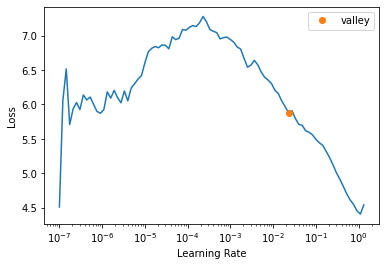

<Figure size 720x720 with 0 Axes>

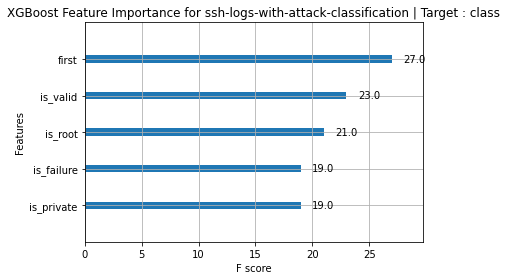

Target Variable: ts
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td']
12
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 17%|█▋        | 7/42 [00:00<00:00, 47.59it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5053814846402683, 'Adjusted R-Squared': 0.44481595214724, 'RMSE': 8656373.187182155, 'Time taken': 0.01921987533569336}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5370362441568544, 'Adjusted R-Squared': 0.480346804665857, 'RMSE': 8374796.882216158, 'Time taken': 0.027199745178222656}
{'Model': 'BayesianRidge', 'R-Squared': -0.0019963397264348703, 'Adjusted R-Squared': -0.12468976908069207, 'RMSE': 12320656.622052789, 'Time taken': 0.010050773620605469}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5447842121683057, 'Adjusted R-Squared': 0.48904350345422076, 'RMSE': 8304422.650467845, 'Time taken': 0.009759664535522461}
{'Model': 'DummyRegressor', 'R-Squared': -0.0019967867441399445, 'Adjusted R-Squared': -0.12469027083525908, 'RMSE': 12320660.0, 'Time taken': 0.008925199508666992}
{'Model': 'ElasticNet', 'R-Squared': 0.40236939303506736, 'Adjusted R-Squared': 0.32919013503936134, 'RMSE': 9515184.24393445, 'Time taken': 0.0096797943115

 29%|██▊       | 12/42 [00:00<00:01, 23.43it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5447842121683141, 'Adjusted R-Squared': 0.4890435034542301, 'RMSE': 8304422.650467768, 'Time taken': 0.11436128616333008}
{'Model': 'GammaRegressor', 'R-Squared': 0.35489556942393696, 'Adjusted R-Squared': 0.2759031901697252, 'RMSE': 9885890.56742622, 'Time taken': 0.01482248306274414}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.5447854766409782, 'Adjusted R-Squared': 0.48904492276028166, 'RMSE': 8304411.116682028, 'Time taken': 0.05405569076538086}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5446613244284508, 'Adjusted R-Squared': 0.4889055682360163, 'RMSE': 8305543.484689601, 'Time taken': 0.12282729148864746}


 45%|████▌     | 19/42 [00:01<00:02, 10.90it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5514685994773323, 'Adjusted R-Squared': 0.49654638716843424, 'RMSE': 8243226.108131075, 'Time taken': 0.9377880096435547}
{'Model': 'HuberRegressor', 'R-Squared': -0.212431705812834, 'Adjusted R-Squared': -0.36089273101440544, 'RMSE': 13552812.463310616, 'Time taken': 0.03247237205505371}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.38194259108244977, 'Adjusted R-Squared': 0.30626209203132126, 'RMSE': 9676431.0, 'Time taken': 0.010521173477172852}
{'Model': 'KernelRidge', 'R-Squared': -15634.634025386971, 'Adjusted R-Squared': -17549.201457067007, 'RMSE': 1539070573.4131465, 'Time taken': 0.027711153030395508}
{'Model': 'Lars', 'R-Squared': 0.4408882110985598, 'Adjusted R-Squared': 0.372425543069812, 'RMSE': 9203438.42655902, 'Time taken': 0.022309541702270508}
{'Model': 'LarsCV', 'R-Squared': 0.4421739480197928, 'Adjusted R-Squared': 0.37386871716507364, 'RMSE': 9192850.193954276, 'Time taken': 0.03794407844543457}
{'Model':

 52%|█████▏    | 22/42 [00:01<00:01, 12.98it/s]

{'Model': 'LassoCV', 'R-Squared': 0.44322953309919666, 'Adjusted R-Squared': 0.3750535575603229, 'RMSE': 9184148.170711307, 'Time taken': 0.08113622665405273}
{'Model': 'LassoLars', 'R-Squared': 0.4408887309560441, 'Adjusted R-Squared': 0.37242612658331486, 'RMSE': 9203434.14791783, 'Time taken': 0.011996030807495117}
{'Model': 'LassoLarsCV', 'R-Squared': 0.4421739480197928, 'Adjusted R-Squared': 0.37386871716507364, 'RMSE': 9192850.193954276, 'Time taken': 0.01935100555419922}
{'Model': 'LassoLarsIC', 'R-Squared': 0.44239579433561593, 'Adjusted R-Squared': 0.3741177283358955, 'RMSE': 9191022.023015628, 'Time taken': 0.014329195022583008}
{'Model': 'LinearRegression', 'R-Squared': 0.4408882110985608, 'Adjusted R-Squared': 0.37242554306981324, 'RMSE': 9203438.426559012, 'Time taken': 0.009721755981445312}
{'Model': 'LinearSVR', 'R-Squared': -15612.551866714786, 'Adjusted R-Squared': -17524.41536059823, 'RMSE': 1537983377.057148, 'Time taken': 0.009908676147460938}


 71%|███████▏  | 30/42 [00:02<00:00, 13.06it/s]

{'Model': 'MLPRegressor', 'R-Squared': -15612.555501792209, 'Adjusted R-Squared': -17524.419440787173, 'RMSE': 1537983556.0903485, 'Time taken': 0.5266003608703613}
{'Model': 'NuSVR', 'R-Squared': -0.2980125560137068, 'Adjusted R-Squared': -0.4569528689949769, 'RMSE': 14022977.368797917, 'Time taken': 0.02776479721069336}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4460592455774609, 'Adjusted R-Squared': 0.3782297654440888, 'RMSE': 9160779.830267094, 'Time taken': 0.02034759521484375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.43885966647043995, 'Adjusted R-Squared': 0.3701486052219224, 'RMSE': 9220119.06409878, 'Time taken': 0.03098893165588379}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -15607.988530951885, 'Adjusted R-Squared': -17519.293249027625, 'RMSE': 1537758609.2563894, 'Time taken': 0.039438724517822266}
{'Model': 'PoissonRegressor', 'R-Squared': 0.44003570015812243, 'Adjusted R-Squared': 0.37146864303462723, 'RMSE': 9210452.268472442, 'Time t

 79%|███████▊  | 33/42 [00:04<00:01,  4.79it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2988600919948907, 'Adjusted R-Squared': -0.45790418489222406, 'RMSE': 14027554.766139105, 'Time taken': 1.6000170707702637}
{'Model': 'RANSACRegressor', 'R-Squared': -1.7462731561877463, 'Adjusted R-Squared': -2.082551501843388, 'RMSE': 20397298.53631996, 'Time taken': 0.12400007247924805}


 83%|████████▎ | 35/42 [00:04<00:01,  5.46it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5478101046157162, 'Adjusted R-Squared': 0.49243991334417125, 'RMSE': 8276776.215787251, 'Time taken': 0.14635896682739258}
{'Model': 'Ridge', 'R-Squared': 0.4407664689787232, 'Adjusted R-Squared': 0.3722888937516281, 'RMSE': 9204440.359571943, 'Time taken': 0.0104522705078125}
{'Model': 'RidgeCV', 'R-Squared': 0.4392876086280275, 'Adjusted R-Squared': 0.3706289484600309, 'RMSE': 9216602.626258545, 'Time taken': 0.011095523834228516}
{'Model': 'SGDRegressor', 'R-Squared': 0.439546340700512, 'Adjusted R-Squared': 0.3709193620107788, 'RMSE': 9214475.951436752, 'Time taken': 0.011824369430541992}
{'Model': 'SVR', 'R-Squared': -0.3003109927237786, 'Adjusted R-Squared': -0.45953274693485335, 'RMSE': 14035387.368350042, 'Time taken': 0.014962196350097656}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4408882110985608, 'Adjusted R-Squared': 0.37242554306981324, 'RMSE': 9203438.426559012, 'Time taken': 0.012108564376831055}
{'Model': 'T

100%|██████████| 42/42 [00:04<00:00,  8.86it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.5447836227571009, 'Adjusted R-Squared': 0.4890428418702153, 'RMSE': 8304428.0, 'Time taken': 0.36500096321105957}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5300789584008061, 'Adjusted R-Squared': 0.4725376063682518, 'RMSE': 8437489.245506799, 'Time taken': 0.043047189712524414}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: ts
ts
Target Standard Deviation: 11959549.0
                               Adjusted R-Squared  R-Squared          RMSE  \
Model                                                                        
HistGradientBoostingRegressor                0.50       0.55    8243226.11   
RandomForestRegressor                        0.49       0.55    8276776.22   
GaussianProcessRegressor                     0.49       0.54    8304411.12   
ExtraTreesRegressor                          0.49       0.54    8304422.65   
DecisionTreeRegressor                        0.49       0.54    8304422.65   
E

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2367959918624899072.000000,2365393383607762944.000000,1537983488.000000,00:00
1,2367966515694665728.000000,2365393383607762944.000000,1537983488.000000,00:00


Better model found at epoch 0 with _rmse value: 1537983488.0.
No improvement since epoch 0: early stopping


,is_private,is_failure,is_root,is_valid,first,class,ts,ts_pred
0,2.00,1.00,1.00,2.00,1.00,1.00,1544547328.00,0.33
1,2.00,2.00,1.00,1.00,1.00,2.00,1515738496.00,0.23
2,2.00,2.00,1.00,2.00,1.00,1.00,1514930432.00,0.25
3,2.00,2.00,1.00,1.00,1.00,1.00,1544700928.00,0.24
4,2.00,2.00,1.00,2.00,1.00,2.00,1514930560.00,0.21
5,2.00,2.00,1.00,1.00,1.00,1.00,1544700544.00,0.24
6,2.00,2.00,1.00,2.00,2.00,1.00,1544678528.00,0.24
7,2.00,1.00,1.00,2.00,1.00,1.00,1544554240.00,0.33
8,2.00,2.00,1.00,2.00,1.00,1.00,1544888960.00,0.25


<Figure size 432x288 with 0 Axes>

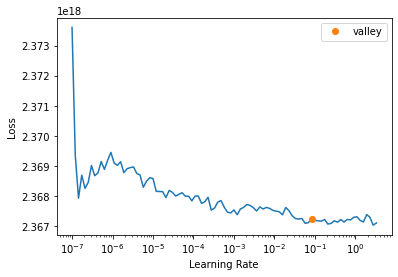

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
         actual     predicted
0 1544679040.00 1534779904.00
1 1544546816.00 1544582144.00
2 1544881152.00 1540350976.00
3 1514930432.00 1541831808.00
4 1544557952.00 1543694336.00
XGBoost RMSE:  8304428.0


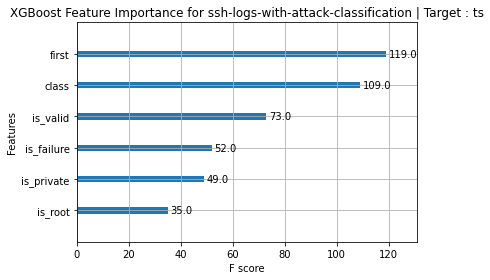

Target Variable: td
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'ts']
12
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 17%|█▋        | 7/42 [00:00<00:00, 47.41it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.027323758601419668, 'Adjusted R-Squared': -0.15311850455261378, 'RMSE': 45125.882815448436, 'Time taken': 0.01732015609741211}
{'Model': 'BaggingRegressor', 'R-Squared': 0.022858837913280916, 'Adjusted R-Squared': -0.09679110030141924, 'RMSE': 44009.93219169268, 'Time taken': 0.027789592742919922}
{'Model': 'BayesianRidge', 'R-Squared': -0.01659447262414293, 'Adjusted R-Squared': -0.14107542845567056, 'RMSE': 44889.61878643844, 'Time taken': 0.010239124298095703}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.010979351062211262, 'Adjusted R-Squared': -0.11012521819547705, 'RMSE': 44276.64697129267, 'Time taken': 0.01002955436706543}
{'Model': 'DummyRegressor', 'R-Squared': -0.016594430347767197, 'Adjusted R-Squared': -0.14107538100259576, 'RMSE': 44889.617, 'Time taken': 0.009353160858154297}
{'Model': 'ElasticNet', 'R-Squared': -0.006659886954772487, 'Adjusted R-Squared': -0.1299243629084179, 'RMSE': 44669.74023201695, 'Time taken': 0.

 29%|██▊       | 12/42 [00:00<00:01, 29.72it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.010979351062211262, 'Adjusted R-Squared': -0.11012521819547705, 'RMSE': 44276.64697129267, 'Time taken': 0.10969400405883789}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.010979566713539501, 'Adjusted R-Squared': -0.11012497613786376, 'RMSE': 44276.64214413448, 'Time taken': 0.027762889862060547}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.010940361464356174, 'Adjusted R-Squared': -0.11016898202980419, 'RMSE': 44277.519709211716, 'Time taken': 0.07247042655944824}


 38%|███▊      | 16/42 [00:00<00:00, 26.50it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.009477192259099487, 'Adjusted R-Squared': -0.11181131481121476, 'RMSE': 44310.258665658606, 'Time taken': 0.1310291290283203}
{'Model': 'HuberRegressor', 'R-Squared': -0.030171081986448467, 'Adjusted R-Squared': -0.15631447978070745, 'RMSE': 45188.37483629359, 'Time taken': 0.01643681526184082}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.02639624004884711, 'Adjusted R-Squared': -0.15207741229972616, 'RMSE': 45105.508, 'Time taken': 0.011356830596923828}
{'Model': 'KernelRidge', 'R-Squared': -0.010511546394594395, 'Adjusted R-Squared': -0.1342476541163813, 'RMSE': 44755.1158226164, 'Time taken': 0.017540454864501953}
{'Model': 'Lars', 'R-Squared': 0.002513691241705196, 'Adjusted R-Squared': -0.11962748942257573, 'RMSE': 44465.73925246621, 'Time taken': 0.022648334503173828}
{'Model': 'LarsCV', 'R-Squared': -0.016594478998177564, 'Adjusted R-Squared': -0.1410754356101993, 'RMSE': 44889.61892716712, 'Time taken': 0.04124784469

 48%|████▊     | 20/42 [00:00<00:00, 25.38it/s]

{'Model': 'LassoCV', 'R-Squared': -0.016594478998177564, 'Adjusted R-Squared': -0.1410754356101993, 'RMSE': 44889.61892716712, 'Time taken': 0.08110570907592773}
{'Model': 'LassoLars', 'R-Squared': 0.0021409934247600404, 'Adjusted R-Squared': -0.12004582370690198, 'RMSE': 44474.04549992402, 'Time taken': 0.014297246932983398}
{'Model': 'LassoLarsCV', 'R-Squared': -0.016594478998177564, 'Adjusted R-Squared': -0.1410754356101993, 'RMSE': 44889.61892716712, 'Time taken': 0.020009994506835938}
{'Model': 'LassoLarsIC', 'R-Squared': -0.016594478998177564, 'Adjusted R-Squared': -0.1410754356101993, 'RMSE': 44889.61892716712, 'Time taken': 0.01276397705078125}
{'Model': 'LinearRegression', 'R-Squared': 0.002513691241704863, 'Adjusted R-Squared': -0.11962748942257617, 'RMSE': 44465.73925246621, 'Time taken': 0.011126279830932617}
{'Model': 'LinearSVR', 'R-Squared': -0.03026679851356051, 'Adjusted R-Squared': -0.15642191669889427, 'RMSE': 45190.474086562135, 'Time taken': 0.01012730598449707}


 71%|███████▏  | 30/42 [00:01<00:00, 18.35it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.03017085917544371, 'Adjusted R-Squared': -0.15631422968672237, 'RMSE': 45188.36994949958, 'Time taken': 0.5382537841796875}
{'Model': 'NuSVR', 'R-Squared': -0.030087163910251125, 'Adjusted R-Squared': -0.15622028602171034, 'RMSE': 45186.534268848496, 'Time taken': 0.028333425521850586}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.01241406439730497, 'Adjusted R-Squared': -0.136383133507179, 'RMSE': 44797.22685747083, 'Time taken': 0.021300554275512695}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.01241406439730497, 'Adjusted R-Squared': -0.136383133507179, 'RMSE': 44797.22685747083, 'Time taken': 0.03311443328857422}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.03022939912909095, 'Adjusted R-Squared': -0.1563799377979591, 'RMSE': 45189.65385666861, 'Time taken': 0.022171974182128906}
{'Model': 'PoissonRegressor', 'R-Squared': 0.010785558433155096, 'Adjusted R-Squared': -0.11034274053421367, 'RMSE': 44280.98462973

 79%|███████▊  | 33/42 [00:03<00:01,  4.69it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.030281642230930217, 'Adjusted R-Squared': -0.15643857801430938, 'RMSE': 45190.79962952343, 'Time taken': 2.026151657104492}
{'Model': 'RANSACRegressor', 'R-Squared': -0.030325684155980692, 'Adjusted R-Squared': -0.1564880128281414, 'RMSE': 45191.76551518963, 'Time taken': 0.13521695137023926}


 83%|████████▎ | 35/42 [00:03<00:01,  5.31it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.011847342666247984, 'Adjusted R-Squared': -0.10915094190523167, 'RMSE': 44257.21350761311, 'Time taken': 0.1424095630645752}
{'Model': 'Ridge', 'R-Squared': 0.0023445609564893832, 'Adjusted R-Squared': -0.11981732953863422, 'RMSE': 44469.50882019638, 'Time taken': 0.011407613754272461}
{'Model': 'RidgeCV', 'R-Squared': 0.0009627368982444429, 'Adjusted R-Squared': -0.12136835654278677, 'RMSE': 44500.294887027856, 'Time taken': 0.01186990737915039}
{'Model': 'SGDRegressor', 'R-Squared': 0.002551492165941416, 'Adjusted R-Squared': -0.11958505981373913, 'RMSE': 44464.89670357578, 'Time taken': 0.011258125305175781}
{'Model': 'SVR', 'R-Squared': -0.030270352830434444, 'Adjusted R-Squared': -0.1564259062382427, 'RMSE': 45190.55203779103, 'Time taken': 0.01412343978881836}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.002513691241704863, 'Adjusted R-Squared': -0.11962748942257617, 'RMSE': 44465.73925246621, 'Time taken': 0.01088786125

100%|██████████| 42/42 [00:04<00:00,  9.83it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.010979449479232684, 'Adjusted R-Squared': -0.1101251077273917, 'RMSE': 44276.645, 'Time taken': 0.38053441047668457}
{'Model': 'LGBMRegressor', 'R-Squared': 0.007425766343750917, 'Adjusted R-Squared': -0.11411393573660611, 'RMSE': 44356.119395274465, 'Time taken': 0.04693341255187988}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: td
td
Target Standard Deviation: 15541.7509765625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
BaggingRegressor                            -0.10       0.02 44009.93   
RandomForestRegressor                       -0.11       0.01 44257.21   
GaussianProcessRegressor                    -0.11       0.01 44276.64   
XGBRegressor                                -0.11       0.01 44276.64   
DecisionTreeRegressor                       -0.11       0.01 44276.65   
ExtraTreeRegressor     

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,286785792.000000,2042389376.000000,45192.800781,00:00
1,289080192.000000,2042363648.000000,45192.519531,00:00
2,281252928.000000,2042264448.000000,45191.421875,00:00
3,278864512.000000,2041968896.000000,45188.148438,00:00
4,280527392.000000,2040926464.000000,45176.613281,00:00
5,281796736.000000,2039574272.000000,45161.644531,00:00
6,281798848.000000,2036596992.000000,45128.671875,00:00
7,282222400.000000,2036128000.000000,45123.476562,00:00
8,282404448.000000,2031482624.000000,45071.972656,00:00
9,283165600.000000,2028792448.000000,45042.117188,00:00


Better model found at epoch 0 with _rmse value: 45192.80078125.
Better model found at epoch 1 with _rmse value: 45192.51953125.
Better model found at epoch 2 with _rmse value: 45191.421875.
Better model found at epoch 3 with _rmse value: 45188.1484375.
Better model found at epoch 4 with _rmse value: 45176.61328125.
Better model found at epoch 5 with _rmse value: 45161.64453125.
Better model found at epoch 6 with _rmse value: 45128.671875.
Better model found at epoch 7 with _rmse value: 45123.4765625.
Better model found at epoch 8 with _rmse value: 45071.97265625.
Better model found at epoch 9 with _rmse value: 45042.1171875.
Better model found at epoch 10 with _rmse value: 45002.58203125.
Better model found at epoch 11 with _rmse value: 44717.8046875.
Better model found at epoch 12 with _rmse value: 44418.40625.
Better model found at epoch 13 with _rmse value: 44269.2890625.
No improvement since epoch 13: early stopping


,is_private,is_failure,is_root,is_valid,first,class,td,td_pred
0,2.00,2.00,1.00,2.00,1.00,1.00,61.00,1054.80
1,2.00,2.00,1.00,2.00,1.00,1.00,13.00,1054.80
2,2.00,2.00,1.00,2.00,1.00,1.00,8.00,1054.80
3,2.00,1.00,1.00,2.00,1.00,1.00,62.00,2003.05
4,2.00,2.00,1.00,2.00,1.00,1.00,8.00,1054.80
5,2.00,2.00,1.00,1.00,1.00,1.00,4.00,7964.17
6,1.00,2.00,2.00,2.00,1.00,1.00,10.00,2132.56
7,2.00,2.00,1.00,2.00,2.00,1.00,0.00,2699.09
8,2.00,2.00,1.00,2.00,1.00,1.00,0.00,1054.80


<Figure size 432x288 with 0 Axes>

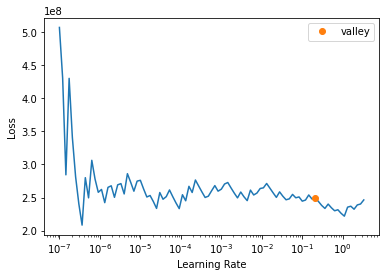

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    9.00    7010.52
1    8.00    1235.02
2   80.00    3379.61
3   13.00    1235.02
4   83.00    1235.02
XGBoost RMSE:  44276.645


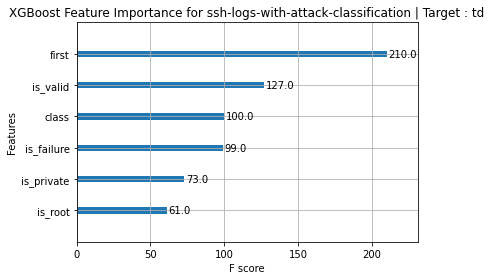

Target Variable: first
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
13
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 17%|█▋        | 7/42 [00:00<00:00, 46.64it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -1.1679247430689004, 'Adjusted R-Squared': -1.3847172173757905, 'RMSE': 0.19499138264972052, 'Time taken': 0.01983809471130371}
{'Model': 'BaggingRegressor', 'R-Squared': -0.263733352989284, 'Adjusted R-Squared': -0.3901066882882125, 'RMSE': 0.14887474876862683, 'Time taken': 0.02995133399963379}
{'Model': 'BayesianRidge', 'R-Squared': -0.2753551668629779, 'Adjusted R-Squared': -0.4028906835492758, 'RMSE': 0.14955773893709737, 'Time taken': 0.010108709335327148}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.25286634614342196, 'Adjusted R-Squared': -0.3781529807577644, 'RMSE': 0.14823327012440757, 'Time taken': 0.009449005126953125}
{'Model': 'DummyRegressor', 'R-Squared': -0.2876857463524123, 'Adjusted R-Squared': -0.41645432098765367, 'RMSE': 0.15027898805368936, 'Time taken': 0.009473085403442383}
{'Model': 'ElasticNet', 'R-Squared': -0.2876857463524123, 'Adjusted R-Squared': -0.41645432098765367, 'RMSE': 0.15027898805368936, 'Time tak

 29%|██▊       | 12/42 [00:00<00:01, 27.82it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.2528663461434175, 'Adjusted R-Squared': -0.3781529807577595, 'RMSE': 0.1482332701244073, 'Time taken': 0.10821676254272461}
{'Model': 'GammaRegressor', 'R-Squared': -0.26890456321065126, 'Adjusted R-Squared': -0.3957950195317166, 'RMSE': 0.14917903632125337, 'Time taken': 0.012127161026000977}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.25286958660978764, 'Adjusted R-Squared': -0.3781565452707665, 'RMSE': 0.1482334618226749, 'Time taken': 0.03720355033874512}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.2530710308266979, 'Adjusted R-Squared': -0.3783781339093679, 'RMSE': 0.1482453782957667, 'Time taken': 0.0786435604095459}


 38%|███▊      | 16/42 [00:00<00:01, 25.41it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.2423496429392813, 'Adjusted R-Squared': -0.3665846072332095, 'RMSE': 0.1476098155301185, 'Time taken': 0.10524153709411621}
{'Model': 'HuberRegressor', 'R-Squared': -0.018181816128013395, 'Adjusted R-Squared': -0.11999999774081482, 'RMSE': 0.13363062082143706, 'Time taken': 0.04252934455871582}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.7105454545454537, 'Adjusted R-Squared': -0.8815999999999993, 'RMSE': 0.1732050807568877, 'Time taken': 0.010526895523071289}
{'Model': 'KernelRidge', 'R-Squared': -60.28533502977309, 'Adjusted R-Squared': -66.4138685327504, 'RMSE': 1.0367441657066416, 'Time taken': 0.015841960906982422}
{'Model': 'Lars', 'R-Squared': -0.2662824323623567, 'Adjusted R-Squared': -0.3929106755985925, 'RMSE': 0.1490248209234055, 'Time taken': 0.02416229248046875}
{'Model': 'LarsCV', 'R-Squared': -0.2774303178510604, 'Adjusted R-Squared': -0.4051733496361667, 'RMSE': 0.14967936338906654, 'Time taken': 0.03995943

 48%|████▊     | 20/42 [00:00<00:00, 24.56it/s]

{'Model': 'LassoCV', 'R-Squared': -0.2824118349251219, 'Adjusted R-Squared': -0.41065301841763424, 'RMSE': 0.14997092715799318, 'Time taken': 0.08203768730163574}
{'Model': 'LassoLars', 'R-Squared': -0.2876857463524123, 'Adjusted R-Squared': -0.41645432098765367, 'RMSE': 0.15027898805368936, 'Time taken': 0.013230085372924805}
{'Model': 'LassoLarsCV', 'R-Squared': -0.2774303178510604, 'Adjusted R-Squared': -0.4051733496361667, 'RMSE': 0.14967936338906654, 'Time taken': 0.01922893524169922}
{'Model': 'LassoLarsIC', 'R-Squared': -0.30448941428979337, 'Adjusted R-Squared': -0.43493835571877293, 'RMSE': 0.1512563434598453, 'Time taken': 0.011736869812011719}
{'Model': 'LinearRegression', 'R-Squared': -0.2662824323623565, 'Adjusted R-Squared': -0.3929106755985923, 'RMSE': 0.14902482092340547, 'Time taken': 0.009554862976074219}
{'Model': 'LinearSVR', 'R-Squared': -0.018181818181450815, 'Adjusted R-Squared': -0.11999999999959599, 'RMSE': 0.1336306209561881, 'Time taken': 0.009984731674194336

 71%|███████▏  | 30/42 [00:01<00:00, 25.54it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.26744987234351614, 'Adjusted R-Squared': -0.39419485957786793, 'RMSE': 0.14909350127812956, 'Time taken': 0.22911310195922852}
{'Model': 'NuSVR', 'R-Squared': -0.018181818181818965, 'Adjusted R-Squared': -0.120000000000001, 'RMSE': 0.13363062095621225, 'Time taken': 0.02446889877319336}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.3542985064652988, 'Adjusted R-Squared': -0.4897283571118287, 'RMSE': 0.15411698968664617, 'Time taken': 0.02084064483642578}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.33124255457079177, 'Adjusted R-Squared': -0.46436681002787106, 'RMSE': 0.15279949315643276, 'Time taken': 0.03269839286804199}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -25.844344791343048, 'Adjusted R-Squared': -28.528779270477354, 'RMSE': 0.6861510336067422, 'Time taken': 0.021602392196655273}
{'Model': 'PoissonRegressor', 'R-Squared': -0.2740335220311334, 'Adjusted R-Squared': -0.4014368742342469, 'RMSE': 0.14948022

 79%|███████▊  | 33/42 [00:01<00:00, 11.78it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.018181818164564323, 'Adjusted R-Squared': -0.11999999998102084, 'RMSE': 0.13363062095507997, 'Time taken': 0.6203107833862305}
{'Model': 'RANSACRegressor', 'R-Squared': -0.018181818181818077, 'Adjusted R-Squared': -0.11999999999999988, 'RMSE': 0.1336306209562122, 'Time taken': 0.061286211013793945}


 86%|████████▌ | 36/42 [00:02<00:00, 12.48it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.28903804429438407, 'Adjusted R-Squared': -0.4179418487238227, 'RMSE': 0.15035787711496904, 'Time taken': 0.16908001899719238}
{'Model': 'Ridge', 'R-Squared': -0.2665220704828235, 'Adjusted R-Squared': -0.393174277531106, 'RMSE': 0.1490389213869561, 'Time taken': 0.010331869125366211}
{'Model': 'RidgeCV', 'R-Squared': -0.26859426236072537, 'Adjusted R-Squared': -0.3954536885967981, 'RMSE': 0.14916079491309744, 'Time taken': 0.010279655456542969}
{'Model': 'SGDRegressor', 'R-Squared': -0.23851075405565902, 'Adjusted R-Squared': -0.36236182946122497, 'RMSE': 0.1473815802232895, 'Time taken': 0.011823892593383789}
{'Model': 'SVR', 'R-Squared': -0.38472727272727636, 'Adjusted R-Squared': -0.5232000000000041, 'RMSE': 0.15583874449479615, 'Time taken': 0.011091947555541992}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.2662824323623565, 'Adjusted R-Squared': -0.3929106755985923, 'RMSE': 0.14902482092340547, 'Time taken': 0.009981393

100%|██████████| 42/42 [00:02<00:00, 16.78it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.25310618746011615, 'Adjusted R-Squared': -0.37841680620612794, 'RMSE': 0.14824747, 'Time taken': 0.3578033447265625}
{'Model': 'LGBMRegressor', 'R-Squared': -0.24171257810107094, 'Adjusted R-Squared': -0.36588383591117823, 'RMSE': 0.14757196423672714, 'Time taken': 0.04411959648132324}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: first
first
Target Standard Deviation: 0.28458329944146
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HuberRegressor                              -0.12      -0.02  0.13        0.04
QuantileRegressor                           -0.12      -0.02  0.13        0.62
LinearSVR                                   -0.12      -0.02  0.13        0.01
RANSACRegressor                             -0.12      -0.02  0.13        0.06
NuSVR                                       -0.12   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,33.390125,0.985417,0.992682,00:00
1,22.604759,3.967091,1.991756,00:00


Better model found at epoch 0 with _rmse value: 0.9926818013191223.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.03
1       1       1.12
2       1       1.17
3       1       1.17
4       1       1.03
XGBoost RMSE:  0.14824747


<Figure size 432x288 with 0 Axes>

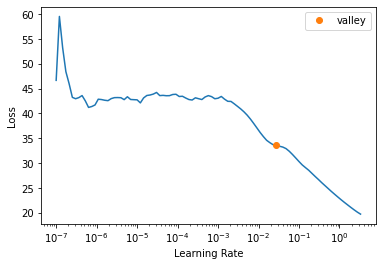

<Figure size 720x720 with 0 Axes>

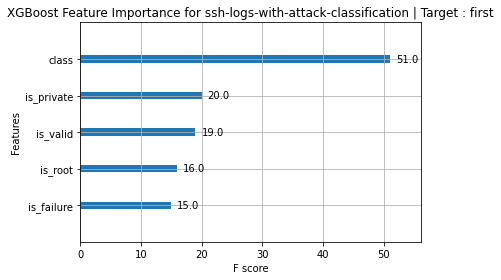

Target Variable: no_failure
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'td', 'ts']
12
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 14%|█▍        | 6/42 [00:00<00:00, 58.98it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6747561483945426, 'Adjusted R-Squared': 0.6349303706469356, 'RMSE': 6.212772531173731, 'Time taken': 0.02722787857055664}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6695830801024505, 'Adjusted R-Squared': 0.629123865421118, 'RMSE': 6.261985311143134, 'Time taken': 0.02946615219116211}
{'Model': 'BayesianRidge', 'R-Squared': 0.6733559016514763, 'Adjusted R-Squared': 0.633358665119004, 'RMSE': 6.22613184809017, 'Time taken': 0.011932134628295898}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6760619576782099, 'Adjusted R-Squared': 0.6363960749449294, 'RMSE': 6.20028827476862, 'Time taken': 0.011127948760986328}
{'Model': 'DummyRegressor', 'R-Squared': -0.015250660263439464, 'Adjusted R-Squared': -0.13956706764263616, 'RMSE': 10.976593, 'Time taken': 0.010411739349365234}
{'Model': 'ElasticNet', 'R-Squared': 0.5962726252429816, 'Adjusted R-Squared': 0.5468366201706938, 'RMSE': 6.921894954199679, 'Time taken': 0.01115560531616211}
{'Model

 29%|██▊       | 12/42 [00:00<00:01, 23.38it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6760619576782099, 'Adjusted R-Squared': 0.6363960749449294, 'RMSE': 6.200288274768621, 'Time taken': 0.11220884323120117}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.6760644792773159, 'Adjusted R-Squared': 0.6363989053112731, 'RMSE': 6.20026414257395, 'Time taken': 0.03413081169128418}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6762436042173332, 'Adjusted R-Squared': 0.6365999639174149, 'RMSE': 6.198549641619677, 'Time taken': 0.12833690643310547}


 38%|███▊      | 16/42 [00:00<00:01, 22.72it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6772808909506921, 'Adjusted R-Squared': 0.6377642653528177, 'RMSE': 6.1886118740800296, 'Time taken': 0.1254112720489502}
{'Model': 'HuberRegressor', 'R-Squared': 0.609585225187566, 'Adjusted R-Squared': 0.5617793343942068, 'RMSE': 6.806816260811997, 'Time taken': 0.017577171325683594}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5802546875595436, 'Adjusted R-Squared': 0.528857302362753, 'RMSE': 7.0578732, 'Time taken': 0.010700225830078125}
{'Model': 'KernelRidge', 'R-Squared': 0.19739823023939962, 'Adjusted R-Squared': 0.09912046251361184, 'RMSE': 9.759576257872233, 'Time taken': 0.029656171798706055}
{'Model': 'Lars', 'R-Squared': 0.6750218908639549, 'Adjusted R-Squared': 0.6352286530105618, 'RMSE': 6.210233920707437, 'Time taken': 0.029228925704956055}
{'Model': 'LarsCV', 'R-Squared': 0.6729849367938905, 'Adjusted R-Squared': 0.6329422759931425, 'RMSE': 6.229666307662367, 'Time taken': 0.03887128829956055}
{'Model': 'Lass

 48%|████▊     | 20/42 [00:00<00:00, 22.87it/s]

{'Model': 'LassoCV', 'R-Squared': 0.672924952871099, 'Adjusted R-Squared': 0.6328749471002132, 'RMSE': 6.230237631021036, 'Time taken': 0.07600736618041992}
{'Model': 'LassoLars', 'R-Squared': -0.015250621773466477, 'Adjusted R-Squared': -0.13956702443960523, 'RMSE': 10.976592394711908, 'Time taken': 0.010338544845581055}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6729849367938905, 'Adjusted R-Squared': 0.6329422759931425, 'RMSE': 6.229666307662367, 'Time taken': 0.019951343536376953}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6740141526444743, 'Adjusted R-Squared': 0.63409751827441, 'RMSE': 6.2198552548179515, 'Time taken': 0.012930154800415039}
{'Model': 'LinearRegression', 'R-Squared': 0.675021890863955, 'Adjusted R-Squared': 0.6352286530105618, 'RMSE': 6.210233920707436, 'Time taken': 0.009642601013183594}
{'Model': 'LinearSVR', 'R-Squared': 0.5895293650548301, 'Adjusted R-Squared': 0.5392676546533808, 'RMSE': 6.979462077834417, 'Time taken': 0.009969234466552734}


 71%|███████▏  | 30/42 [00:01<00:00, 17.84it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6738493907585902, 'Adjusted R-Squared': 0.6339125814637236, 'RMSE': 6.22142689609178, 'Time taken': 0.5390958786010742}
{'Model': 'NuSVR', 'R-Squared': 0.5118585148576649, 'Adjusted R-Squared': 0.4520860881055423, 'RMSE': 7.611211046551893, 'Time taken': 0.029123306274414062}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6118616159552585, 'Adjusted R-Squared': 0.5643344668885555, 'RMSE': 6.786943003685607, 'Time taken': 0.021334171295166016}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.67486253482907, 'Adjusted R-Squared': 0.6350497839918132, 'RMSE': 6.211756357043381, 'Time taken': 0.03304934501647949}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.573123822157823, 'Adjusted R-Squared': 0.5208532697689849, 'RMSE': 7.117571933015816, 'Time taken': 0.021599292755126953}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6755065263490794, 'Adjusted R-Squared': 0.6357726316163136, 'RMSE': 6.205601573846379, 'Time taken': 0.0135

 79%|███████▊  | 33/42 [00:02<00:01,  8.32it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.18585476302221804, 'Adjusted R-Squared': -0.3310614686984079, 'RMSE': 11.86305807479934, 'Time taken': 0.8693594932556152}
{'Model': 'RANSACRegressor', 'R-Squared': 0.30321314494643303, 'Adjusted R-Squared': 0.2178923055521188, 'RMSE': 9.093495995013287, 'Time taken': 0.10174846649169922}


 83%|████████▎ | 35/42 [00:02<00:00,  8.83it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6755363705828257, 'Adjusted R-Squared': 0.6358061302460288, 'RMSE': 6.2053161972556845, 'Time taken': 0.149993896484375}
{'Model': 'Ridge', 'R-Squared': 0.6747931241463517, 'Adjusted R-Squared': 0.6349718740418234, 'RMSE': 6.212419367749653, 'Time taken': 0.011243104934692383}
{'Model': 'RidgeCV', 'R-Squared': 0.6723402298442755, 'Adjusted R-Squared': 0.6322186253354114, 'RMSE': 6.235804146610024, 'Time taken': 0.011240243911743164}
{'Model': 'SGDRegressor', 'R-Squared': 0.6745782645427343, 'Adjusted R-Squared': 0.6347307050989874, 'RMSE': 6.214471257891279, 'Time taken': 0.011343955993652344}
{'Model': 'SVR', 'R-Squared': 0.5159431272824198, 'Adjusted R-Squared': 0.45667085715373645, 'RMSE': 7.5793000565237305, 'Time taken': 0.012708663940429688}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.675021890863955, 'Adjusted R-Squared': 0.6352286530105618, 'RMSE': 6.210233920707436, 'Time taken': 0.010933637619018555}
{'Model': 'Twee

100%|██████████| 42/42 [00:03<00:00, 13.32it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6760627936657438, 'Adjusted R-Squared': 0.6363970132982839, 'RMSE': 6.20028, 'Time taken': 0.3626854419708252}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6613103203838326, 'Adjusted R-Squared': 0.6198381147165468, 'RMSE': 6.339892397111113, 'Time taken': 0.039543867111206055}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: no_failure
no_failure
Target Standard Deviation: 9.739099502563477
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.64       0.68  6.19        0.13
GradientBoostingRegressor                    0.64       0.68  6.20        0.13
GaussianProcessRegressor                     0.64       0.68  6.20        0.03
XGBRegressor                                 0.64       0.68  6.20        0.36
DecisionTreeRegressor                        0.64    

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,174.411423,191.270950,13.830074,00:00
1,139.436035,165.461151,12.863171,00:00
2,120.202362,124.516106,11.158678,00:00
3,104.054977,125.309280,11.194162,00:00


Better model found at epoch 0 with _rmse value: 13.830074310302734.
Better model found at epoch 1 with _rmse value: 12.863170623779297.
Better model found at epoch 2 with _rmse value: 11.15867805480957.
No improvement since epoch 2: early stopping


,is_private,is_failure,is_root,is_valid,first,class,no_failure,no_failure_pred
0,2.00,2.00,2.00,2.00,1.00,1.00,2.00,5.22
1,2.00,2.00,1.00,2.00,1.00,1.00,2.00,5.29
2,2.00,2.00,1.00,1.00,1.00,1.00,5.00,5.46
3,2.00,2.00,1.00,1.00,1.00,2.00,36.00,5.81
4,2.00,2.00,1.00,1.00,1.00,2.00,28.00,5.81
5,2.00,1.00,1.00,2.00,1.00,1.00,0.00,4.72
6,2.00,1.00,1.00,2.00,2.00,1.00,0.00,4.85
7,2.00,1.00,1.00,2.00,1.00,1.00,0.00,4.72
8,2.00,2.00,1.00,2.00,2.00,1.00,4.00,5.14


<Figure size 432x288 with 0 Axes>

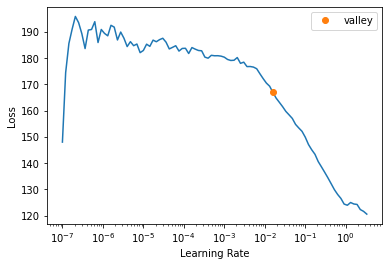

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.00
1   18.00      23.73
2    2.00       4.36
3    6.00       4.62
4   20.00      23.73
XGBoost RMSE:  6.20028


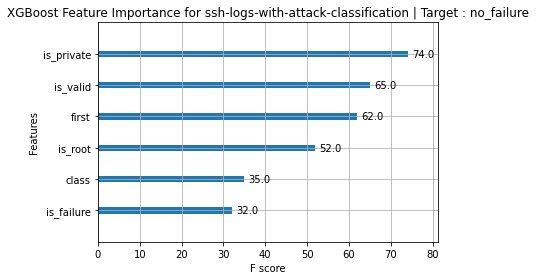

Target Variable: ip_success
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'no_failure', 'td', 'ts']
12
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 17%|█▋        | 7/42 [00:00<00:00, 43.98it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.11104863669743259, 'Adjusted R-Squared': 0.0021974493542611384, 'RMSE': 8.191577263524543, 'Time taken': 0.02436661720275879}
{'Model': 'BaggingRegressor', 'R-Squared': 0.18454556188642013, 'Adjusted R-Squared': 0.08469399803577782, 'RMSE': 7.845640101481826, 'Time taken': 0.028186798095703125}
{'Model': 'BayesianRidge', 'R-Squared': 0.17816548805716226, 'Adjusted R-Squared': 0.07753269067640667, 'RMSE': 7.876272245639757, 'Time taken': 0.010457038879394531}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.22179668343784587, 'Adjusted R-Squared': 0.126506481409827, 'RMSE': 7.664345436736353, 'Time taken': 0.010432720184326172}
{'Model': 'DummyRegressor', 'R-Squared': -0.012166757607518619, 'Adjusted R-Squared': -0.1361055442533372, 'RMSE': 8.740869, 'Time taken': 0.009438753128051758}
{'Model': 'ElasticNet', 'R-Squared': 0.16235906072310757, 'Adjusted R-Squared': 0.05979078244430447, 'RMSE': 7.951654090548027, 'Time taken': 0.0104010105133

 29%|██▊       | 12/42 [00:00<00:01, 27.02it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.22179668343784598, 'Adjusted R-Squared': 0.12650648140982723, 'RMSE': 7.664345436736352, 'Time taken': 0.11302781105041504}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.22178987701026298, 'Adjusted R-Squared': 0.12649884154213198, 'RMSE': 7.6643789541327765, 'Time taken': 0.033246517181396484}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.20773775144067042, 'Adjusted R-Squared': 0.11072604753544646, 'RMSE': 7.733267140646031, 'Time taken': 0.08731603622436523}


 45%|████▌     | 19/42 [00:00<00:00, 28.24it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.06503203810261415, 'Adjusted R-Squared': -0.04945383478277998, 'RMSE': 8.400920916711929, 'Time taken': 0.11594009399414062}
{'Model': 'HuberRegressor', 'R-Squared': 0.1776245231401471, 'Adjusted R-Squared': 0.07692548515730802, 'RMSE': 7.878864060643067, 'Time taken': 0.01670694351196289}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.24076055966532028, 'Adjusted R-Squared': 0.1477924649304616, 'RMSE': 7.570384, 'Time taken': 0.01086568832397461}
{'Model': 'KernelRidge', 'R-Squared': -0.30646887520589594, 'Adjusted R-Squared': -0.4664446558433524, 'RMSE': 9.93065891579557, 'Time taken': 0.016945838928222656}
{'Model': 'Lars', 'R-Squared': 0.17456286018657352, 'Adjusted R-Squared': 0.0734889246992152, 'RMSE': 7.8935167448105235, 'Time taken': 0.02321481704711914}
{'Model': 'LarsCV', 'R-Squared': 0.18272546389897293, 'Adjusted R-Squared': 0.08265103090701054, 'RMSE': 7.854390973271, 'Time taken': 0.04233288764953613}
{'Model': '

 55%|█████▍    | 23/42 [00:00<00:00, 29.42it/s]

{'Model': 'LassoCV', 'R-Squared': 0.18118764986209102, 'Adjusted R-Squared': 0.08092491311051042, 'RMSE': 7.861777056902671, 'Time taken': 0.07976555824279785}
{'Model': 'LassoLars', 'R-Squared': -0.012166793164516188, 'Adjusted R-Squared': -0.13610558416425267, 'RMSE': 8.740868250796243, 'Time taken': 0.011055469512939453}
{'Model': 'LassoLarsCV', 'R-Squared': 0.18272546389897293, 'Adjusted R-Squared': 0.08265103090701054, 'RMSE': 7.854390973271, 'Time taken': 0.019842863082885742}
{'Model': 'LassoLarsIC', 'R-Squared': 0.17456286018657352, 'Adjusted R-Squared': 0.0734889246992152, 'RMSE': 7.8935167448105235, 'Time taken': 0.011678695678710938}
{'Model': 'LinearRegression', 'R-Squared': 0.17456286018657408, 'Adjusted R-Squared': 0.07348892469921586, 'RMSE': 7.89351674481052, 'Time taken': 0.011548995971679688}
{'Model': 'LinearSVR', 'R-Squared': 0.1168774977785697, 'Adjusted R-Squared': 0.008740048526966082, 'RMSE': 8.164676976379456, 'Time taken': 0.01008462905883789}


 64%|██████▍   | 27/42 [00:01<00:01, 13.63it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.22041347345745765, 'Adjusted R-Squared': 0.12495389877877905, 'RMSE': 7.671153871125564, 'Time taken': 0.562309741973877}
{'Model': 'NuSVR', 'R-Squared': 0.12895963118187104, 'Adjusted R-Squared': 0.022301626836794042, 'RMSE': 8.108633537163087, 'Time taken': 0.029303789138793945}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.08012269930304938, 'Adjusted R-Squared': -0.03251533751698532, 'RMSE': 8.332848439747142, 'Time taken': 0.023490428924560547}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.17553563486294377, 'Adjusted R-Squared': 0.07458081464207977, 'RMSE': 7.888864133203365, 'Time taken': 0.034012556076049805}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.045940132067082695, 'Adjusted R-Squared': -0.17401443395284777, 'RMSE': 8.885501514067801, 'Time taken': 0.021755695343017578}
{'Model': 'PoissonRegressor', 'R-Squared': 0.20779927166838563, 'Adjusted R-Squared': 0.11079510085226962, 'RMSE': 7.732966885526971,

 76%|███████▌  | 32/42 [00:02<00:01,  8.25it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.25357069395519494, 'Adjusted R-Squared': -0.407069146276239, 'RMSE': 9.727538247240366, 'Time taken': 0.9179151058197021}
{'Model': 'RANSACRegressor', 'R-Squared': -0.3844752677467025, 'Adjusted R-Squared': -0.5540028515524211, 'RMSE': 10.222829857178368, 'Time taken': 0.11824154853820801}


 81%|████████  | 34/42 [00:02<00:00,  8.12it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.21722044655742545, 'Adjusted R-Squared': 0.12136988899302859, 'RMSE': 7.686847556338804, 'Time taken': 0.14086461067199707}
{'Model': 'Ridge', 'R-Squared': 0.1749512445386895, 'Adjusted R-Squared': 0.07392486631893724, 'RMSE': 7.891659499150028, 'Time taken': 0.010785341262817383}
{'Model': 'RidgeCV', 'R-Squared': 0.17751741243637187, 'Adjusted R-Squared': 0.07680525885715217, 'RMSE': 7.8793771372249495, 'Time taken': 0.009874105453491211}
{'Model': 'SGDRegressor', 'R-Squared': 0.17515477718729056, 'Adjusted R-Squared': 0.07415332133267316, 'RMSE': 7.890686035811659, 'Time taken': 0.010643482208251953}
{'Model': 'SVR', 'R-Squared': 0.2094329042743166, 'Adjusted R-Squared': 0.11262877010382477, 'RMSE': 7.724989522091171, 'Time taken': 0.013299226760864258}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.17456286018657408, 'Adjusted R-Squared': 0.07348892469921586, 'RMSE': 7.89351674481052, 'Time taken': 0.010263442993164062}
{'Mod

100%|██████████| 42/42 [00:03<00:00, 13.23it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.2218004179698383, 'Adjusted R-Squared': 0.12651067323145126, 'RMSE': 7.6643267, 'Time taken': 0.3656628131866455}
{'Model': 'LGBMRegressor', 'R-Squared': 0.06503203810261415, 'Adjusted R-Squared': -0.04945383478277998, 'RMSE': 8.400920916711929, 'Time taken': 0.05352425575256348}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: ip_success
ip_success
Target Standard Deviation: 9.522838592529297
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KNeighborsRegressor                          0.15       0.24  7.57        0.01
XGBRegressor                                 0.13       0.22  7.66        0.37
ExtraTreesRegressor                          0.13       0.22  7.66        0.11
DecisionTreeRegressor                        0.13       0.22  7.66        0.01
ExtraTreeRegressor                           0.1

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,217.024323,112.652992,10.613811,00:00
1,195.829391,92.965843,9.641880,00:00
2,157.968323,75.513527,8.689852,00:00
3,143.453995,74.982796,8.659261,00:00
4,127.491936,76.285805,8.734175,00:00


Better model found at epoch 0 with _rmse value: 10.613811492919922.
Better model found at epoch 1 with _rmse value: 9.64188003540039.
Better model found at epoch 2 with _rmse value: 8.689851760864258.
Better model found at epoch 3 with _rmse value: 8.659260749816895.
No improvement since epoch 3: early stopping


,is_private,is_failure,is_root,is_valid,first,class,ip_success,ip_success_pred
0,2.00,2.00,1.00,2.00,2.00,1.00,0.00,6.30
1,2.00,1.00,1.00,2.00,1.00,1.00,16.00,6.82
2,2.00,2.00,2.00,2.00,1.00,1.00,2.00,5.78
3,2.00,1.00,1.00,2.00,2.00,1.00,1.00,5.61
4,2.00,2.00,1.00,2.00,1.00,1.00,20.00,5.43
5,2.00,1.00,1.00,2.00,1.00,1.00,12.00,6.82
6,2.00,2.00,2.00,2.00,1.00,1.00,9.00,5.78
7,2.00,2.00,1.00,2.00,1.00,1.00,9.00,5.43
8,2.00,1.00,1.00,2.00,1.00,1.00,9.00,6.82


<Figure size 432x288 with 0 Axes>

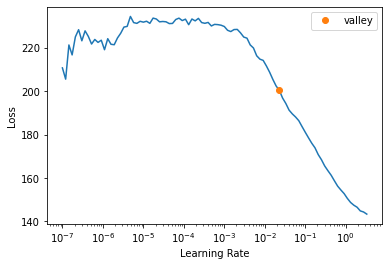

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.00       9.10
1    1.00       2.60
2   13.00      11.49
3    8.00       9.10
4    5.00       9.10
XGBoost RMSE:  7.6643267


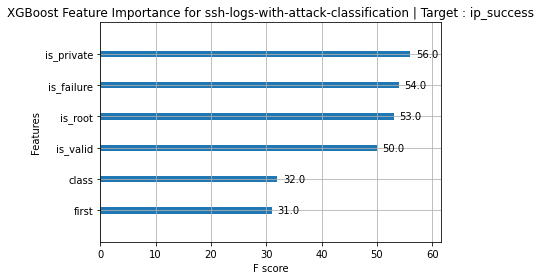

Target Variable: ip_failure
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_success', 'no_failure', 'td', 'ts']
12
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 17%|█▋        | 7/42 [00:00<00:00, 42.89it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5876961119608882, 'Adjusted R-Squared': 0.5372099215887521, 'RMSE': 5.775692103386207, 'Time taken': 0.02443528175354004}
{'Model': 'BaggingRegressor', 'R-Squared': 0.583665518757263, 'Adjusted R-Squared': 0.5326857863601933, 'RMSE': 5.803854399045165, 'Time taken': 0.030556678771972656}
{'Model': 'BayesianRidge', 'R-Squared': 0.5674795502995089, 'Adjusted R-Squared': 0.5145178625810815, 'RMSE': 5.9155978328979835, 'Time taken': 0.01339101791381836}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5975454933528466, 'Adjusted R-Squared': 0.5482653496817667, 'RMSE': 5.706288377323068, 'Time taken': 0.010599374771118164}
{'Model': 'DummyRegressor', 'R-Squared': -0.004129406670944302, 'Adjusted R-Squared': -0.12708402789595774, 'RMSE': 9.013432, 'Time taken': 0.009598255157470703}
{'Model': 'ElasticNet', 'R-Squared': 0.5602903457314344, 'Adjusted R-Squared': 0.5064483472495693, 'RMSE': 5.964558724085081, 'Time taken': 0.010416507720947266}
{'M

 29%|██▊       | 12/42 [00:00<00:01, 28.35it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5975454933528466, 'Adjusted R-Squared': 0.5482653496817667, 'RMSE': 5.706288377323068, 'Time taken': 0.1100153923034668}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.5975411502469451, 'Adjusted R-Squared': 0.5482604747669793, 'RMSE': 5.706319167073779, 'Time taken': 0.028154373168945312}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5982833887557734, 'Adjusted R-Squared': 0.5490935996238273, 'RMSE': 5.701054772400989, 'Time taken': 0.07588076591491699}


 45%|████▌     | 19/42 [00:00<00:00, 25.27it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6092233851883346, 'Adjusted R-Squared': 0.5613731874562939, 'RMSE': 5.62289018003766, 'Time taken': 0.10567212104797363}
{'Model': 'HuberRegressor', 'R-Squared': 0.5730858511961572, 'Adjusted R-Squared': 0.5208106493018091, 'RMSE': 5.877133994882764, 'Time taken': 0.018623828887939453}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5705696150743824, 'Adjusted R-Squared': 0.5179863026345108, 'RMSE': 5.8944287, 'Time taken': 0.010699987411499023}
{'Model': 'KernelRidge', 'R-Squared': 0.2213541004675076, 'Adjusted R-Squared': 0.12600970460638616, 'RMSE': 7.937163355992909, 'Time taken': 0.032240867614746094}
{'Model': 'Lars', 'R-Squared': 0.5624560860743669, 'Adjusted R-Squared': 0.5088792802875548, 'RMSE': 5.949851711429218, 'Time taken': 0.04832291603088379}
{'Model': 'LarsCV', 'R-Squared': 0.5624560860743669, 'Adjusted R-Squared': 0.5088792802875548, 'RMSE': 5.949851711429218, 'Time taken': 0.06810307502746582}
{'Model': 'Lasso

 55%|█████▍    | 23/42 [00:00<00:00, 28.32it/s]

{'Model': 'LassoCV', 'R-Squared': 0.5630364239539799, 'Adjusted R-Squared': 0.5095306799483448, 'RMSE': 5.9459045990071875, 'Time taken': 0.06411552429199219}
{'Model': 'LassoLars', 'R-Squared': -0.004129404678710147, 'Adjusted R-Squared': -0.1270840256597765, 'RMSE': 9.013431462945364, 'Time taken': 0.011289834976196289}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5624560860743669, 'Adjusted R-Squared': 0.5088792802875548, 'RMSE': 5.949851711429218, 'Time taken': 0.02005600929260254}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5624560860743669, 'Adjusted R-Squared': 0.5088792802875548, 'RMSE': 5.949851711429218, 'Time taken': 0.01185154914855957}
{'Model': 'LinearRegression', 'R-Squared': 0.5624560860743668, 'Adjusted R-Squared': 0.5088792802875546, 'RMSE': 5.949851711429218, 'Time taken': 0.011252403259277344}
{'Model': 'LinearSVR', 'R-Squared': 0.5572511889737952, 'Adjusted R-Squared': 0.5030370488481375, 'RMSE': 5.985135954885338, 'Time taken': 0.009943962097167969}


 71%|███████▏  | 30/42 [00:01<00:00, 16.65it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6059595431192089, 'Adjusted R-Squared': 0.5577096912562549, 'RMSE': 5.646323087340463, 'Time taken': 0.5455667972564697}
{'Model': 'NuSVR', 'R-Squared': 0.6097775710125455, 'Adjusted R-Squared': 0.5619952327691837, 'RMSE': 5.61890167165431, 'Time taken': 0.028902530670166016}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5197866956683292, 'Adjusted R-Squared': 0.4609850665664921, 'RMSE': 6.233219379631216, 'Time taken': 0.020871639251708984}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5686742854463862, 'Adjusted R-Squared': 0.5158588918275764, 'RMSE': 5.907421965113768, 'Time taken': 0.03377175331115723}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.20789666218495828, 'Adjusted R-Squared': -0.3558023759218918, 'RMSE': 9.885763325398004, 'Time taken': 0.02131819725036621}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6126912110262619, 'Adjusted R-Squared': 0.5652656450294777, 'RMSE': 5.597885284609088, 'Time taken': 0

 79%|███████▊  | 33/42 [00:02<00:01,  6.71it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.19249427863166457, 'Adjusted R-Squared': -0.33851398621921525, 'RMSE': 9.82253240548995, 'Time taken': 1.0261893272399902}
{'Model': 'RANSACRegressor', 'R-Squared': 0.28775448203374376, 'Adjusted R-Squared': 0.2005407451399165, 'RMSE': 7.591195579532772, 'Time taken': 0.1267712116241455}


 83%|████████▎ | 35/42 [00:02<00:00,  7.42it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5852504908250924, 'Adjusted R-Squared': 0.5344648366404099, 'RMSE': 5.792796320442128, 'Time taken': 0.14589881896972656}
{'Model': 'Ridge', 'R-Squared': 0.5633019783930742, 'Adjusted R-Squared': 0.5098287512575322, 'RMSE': 5.944097581884433, 'Time taken': 0.010256528854370117}
{'Model': 'RidgeCV', 'R-Squared': 0.5695794600328061, 'Adjusted R-Squared': 0.5168749041184559, 'RMSE': 5.901220089805048, 'Time taken': 0.010716915130615234}
{'Model': 'SGDRegressor', 'R-Squared': 0.5626639725839024, 'Adjusted R-Squared': 0.5091126222880538, 'RMSE': 5.9484380923400275, 'Time taken': 0.011284351348876953}
{'Model': 'SVR', 'R-Squared': 0.6204296411444954, 'Adjusted R-Squared': 0.5739516380193316, 'RMSE': 5.541680246208106, 'Time taken': 0.013211965560913086}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5624560860743668, 'Adjusted R-Squared': 0.5088792802875546, 'RMSE': 5.949851711429218, 'Time taken': 0.011301517486572266}
{'Model': 'Twe

100%|██████████| 42/42 [00:03<00:00, 12.75it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.597553036341413, 'Adjusted R-Squared': 0.5482738163015861, 'RMSE': 5.706235, 'Time taken': 0.37384939193725586}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5790650104919144, 'Adjusted R-Squared': 0.5275219505521489, 'RMSE': 5.835832682426469, 'Time taken': 0.038086652755737305}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: ip_failure
ip_failure
Target Standard Deviation: 9.805240631103516
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
SVR                                          0.57       0.62  5.54        0.01
PoissonRegressor                             0.57       0.61  5.60        0.01
NuSVR                                        0.56       0.61  5.62        0.03
HistGradientBoostingRegressor                0.56       0.61  5.62        0.11
MLPRegressor                                 0.56   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,194.782684,114.671089,10.708459,00:00
1,160.273911,102.178352,10.108331,00:00
2,130.937225,76.456612,8.743947,00:00
3,115.551186,78.660042,8.869050,00:00


Better model found at epoch 0 with _rmse value: 10.70845890045166.
Better model found at epoch 1 with _rmse value: 10.108330726623535.
Better model found at epoch 2 with _rmse value: 8.74394702911377.
No improvement since epoch 2: early stopping


,is_private,is_failure,is_root,is_valid,first,class,ip_failure,ip_failure_pred
0,2.00,2.00,1.00,1.00,1.00,2.00,12.00,5.11
1,2.00,1.00,1.00,2.00,1.00,1.00,0.00,3.01
2,2.00,2.00,1.00,1.00,1.00,2.00,27.00,5.11
3,2.00,1.00,1.00,2.00,1.00,1.00,0.00,3.01
4,2.00,2.00,1.00,2.00,1.00,1.00,2.00,4.48
5,2.00,2.00,2.00,2.00,1.00,2.00,7.00,3.97
6,2.00,2.00,1.00,1.00,1.00,1.00,5.00,4.62
7,2.00,2.00,1.00,2.00,1.00,1.00,2.00,4.48
8,2.00,2.00,1.00,2.00,1.00,1.00,3.00,4.48


<Figure size 432x288 with 0 Axes>

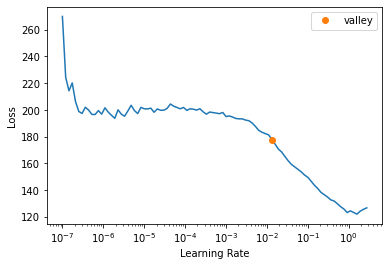

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   16.00      24.67
1   30.00      24.67
2    0.00       0.00
3    0.00       0.00
4    0.00       0.00
XGBoost RMSE:  5.706235


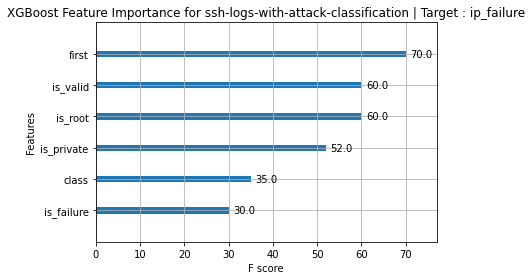

Target Variable: not_valid_count
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
12
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


 17%|█▋        | 7/42 [00:00<00:00, 45.78it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7415812770438439, 'Adjusted R-Squared': 0.7099381681104371, 'RMSE': 2.684962850146103, 'Time taken': 0.01920318603515625}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7472644014779357, 'Adjusted R-Squared': 0.7163171853323769, 'RMSE': 2.6552749723965987, 'Time taken': 0.02901148796081543}
{'Model': 'BayesianRidge', 'R-Squared': 0.7057183440905279, 'Adjusted R-Squared': 0.6696838556118171, 'RMSE': 2.865219436951808, 'Time taken': 0.010791301727294922}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7428881230238062, 'Adjusted R-Squared': 0.7114050360471295, 'RMSE': 2.6781651997325766, 'Time taken': 0.010857820510864258}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004720522515360148, 'Adjusted R-Squared': -0.1229788341598872, 'RMSE': 5.2829776, 'Time taken': 0.01002192497253418}
{'Model': 'ElasticNet', 'R-Squared': 0.6193725027217236, 'Adjusted R-Squared': 0.5727650540754041, 'RMSE': 3.258564882101612, 'Time taken': 0.010480880737304688}
{

 29%|██▊       | 12/42 [00:00<00:01, 29.19it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7428881230238059, 'Adjusted R-Squared': 0.7114050360471291, 'RMSE': 2.6781651997325784, 'Time taken': 0.1059105396270752}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.7428913267442394, 'Adjusted R-Squared': 0.7114086320598606, 'RMSE': 2.6781485141570154, 'Time taken': 0.028514623641967773}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7428911623614676, 'Adjusted R-Squared': 0.711408447548586, 'RMSE': 2.678149370295784, 'Time taken': 0.07667922973632812}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7412042972396489, 'Adjusted R-Squared': 0.7095150275138916, 'RMSE': 2.686920540919201, 'Time taken': 0.08111381530761719}


 48%|████▊     | 20/42 [00:00<00:00, 26.19it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.5734037657164909, 'Adjusted R-Squared': 0.5211674921307551, 'RMSE': 3.449727587846574, 'Time taken': 0.05793642997741699}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7471281707990881, 'Adjusted R-Squared': 0.7161642733459153, 'RMSE': 2.6559906, 'Time taken': 0.010457992553710938}
{'Model': 'KernelRidge', 'R-Squared': 0.44697535493532226, 'Adjusted R-Squared': 0.37925805145801483, 'RMSE': 3.927792494557723, 'Time taken': 0.015159130096435547}
{'Model': 'Lars', 'R-Squared': 0.7047723495464072, 'Adjusted R-Squared': 0.6686220250010694, 'RMSE': 2.8698209931879575, 'Time taken': 0.023467063903808594}
{'Model': 'LarsCV', 'R-Squared': 0.7066025507675109, 'Adjusted R-Squared': 0.6706763324941449, 'RMSE': 2.860911740590353, 'Time taken': 0.041063785552978516}
{'Model': 'Lasso', 'R-Squared': 0.6652010101483012, 'Adjusted R-Squared': 0.624205215472583, 'RMSE': 3.0561056414420325, 'Time taken': 0.020807743072509766}
{'Model': 'LassoCV', 'R-Squared': 0

 71%|███████▏  | 30/42 [00:01<00:00, 18.59it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7498382173610003, 'Adjusted R-Squared': 0.71920616234398, 'RMSE': 2.6417199416567816, 'Time taken': 0.5429646968841553}
{'Model': 'NuSVR', 'R-Squared': 0.6512734261519334, 'Adjusted R-Squared': 0.6085722130276804, 'RMSE': 3.119024703993669, 'Time taken': 0.026076555252075195}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6545894077550567, 'Adjusted R-Squared': 0.6122942331944514, 'RMSE': 3.1041601460805395, 'Time taken': 0.020494699478149414}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7059381653335699, 'Adjusted R-Squared': 0.6699305937417621, 'RMSE': 2.86414911240459, 'Time taken': 0.03152132034301758}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.6079647509393751, 'Adjusted R-Squared': 0.5599604347278699, 'RMSE': 3.307035460924744, 'Time taken': 0.020730972290039062}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7255013534599283, 'Adjusted R-Squared': 0.6918892742917562, 'RMSE': 2.7672372606820113, 'Time taken': 0.

 79%|███████▊  | 33/42 [00:02<00:01,  8.98it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2853550119125525, 'Adjusted R-Squared': -0.4427454215344977, 'RMSE': 5.988083404323411, 'Time taken': 0.798018217086792}
{'Model': 'RANSACRegressor', 'R-Squared': -0.2853550119128898, 'Adjusted R-Squared': -0.4427454215348763, 'RMSE': 5.988083404324196, 'Time taken': 0.07787322998046875}


 83%|████████▎ | 35/42 [00:02<00:00,  9.33it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7396884724506482, 'Adjusted R-Squared': 0.7078135915262378, 'RMSE': 2.6947780017397767, 'Time taken': 0.16016650199890137}
{'Model': 'Ridge', 'R-Squared': 0.7049766798294206, 'Adjusted R-Squared': 0.6688513753187374, 'RMSE': 2.8688277040568004, 'Time taken': 0.011843442916870117}
{'Model': 'RidgeCV', 'R-Squared': 0.7058558800801384, 'Adjusted R-Squared': 0.6698382327430126, 'RMSE': 2.864549811718695, 'Time taken': 0.011871337890625}
{'Model': 'SGDRegressor', 'R-Squared': 0.7041228976889631, 'Adjusted R-Squared': 0.6678930484263872, 'RMSE': 2.872975824178656, 'Time taken': 0.010532617568969727}
{'Model': 'SVR', 'R-Squared': 0.6527483414017523, 'Adjusted R-Squared': 0.610227730144824, 'RMSE': 3.112421863946336, 'Time taken': 0.011778593063354492}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.7047723495464069, 'Adjusted R-Squared': 0.668622025001069, 'RMSE': 2.8698209931879592, 'Time taken': 0.01134037971496582}
{'Model': 'Tweedie

100%|██████████| 42/42 [00:02<00:00, 14.16it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7428902588961657, 'Adjusted R-Squared': 0.7114074334548799, 'RMSE': 2.678154, 'Time taken': 0.36309361457824707}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6322790097175746, 'Adjusted R-Squared': 0.5872519496829919, 'RMSE': 3.2028419163343242, 'Time taken': 0.042995452880859375}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: not_valid_count
not_valid_count
Target Standard Deviation: 6.087743759155273
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
MLPRegressor                                 0.72       0.75  2.64        0.54
BaggingRegressor                             0.72       0.75  2.66        0.03
KNeighborsRegressor                          0.72       0.75  2.66        0.01
GaussianProcessRegressor                     0.71       0.74  2.68        0.03
GradientBoostingRegressor               

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,43.384071,33.538097,5.791209,00:00
1,39.648865,27.358204,5.230507,00:00
2,38.319443,23.460068,4.843559,00:00
3,35.406292,16.414759,4.051513,00:00
4,32.427711,16.603909,4.074790,00:00


Better model found at epoch 0 with _rmse value: 5.791208744049072.
Better model found at epoch 1 with _rmse value: 5.230506896972656.
Better model found at epoch 2 with _rmse value: 4.843559265136719.
Better model found at epoch 3 with _rmse value: 4.051513195037842.
No improvement since epoch 3: early stopping


,is_private,is_failure,is_root,is_valid,first,class,not_valid_count,not_valid_count_pred
0,2.00,1.00,1.00,2.00,1.00,1.00,0.00,3.00
1,2.00,2.00,1.00,2.00,1.00,1.00,0.00,2.54
2,2.00,2.00,1.00,2.00,1.00,1.00,0.00,2.54
3,2.00,2.00,1.00,2.00,1.00,1.00,0.00,2.54
4,2.00,2.00,1.00,2.00,1.00,1.00,0.00,2.54
5,2.00,2.00,1.00,1.00,1.00,1.00,2.00,4.60
6,1.00,2.00,2.00,2.00,1.00,2.00,0.00,2.28
7,2.00,2.00,1.00,2.00,1.00,2.00,0.00,4.04
8,2.00,2.00,1.00,1.00,1.00,1.00,5.00,4.60


<Figure size 432x288 with 0 Axes>

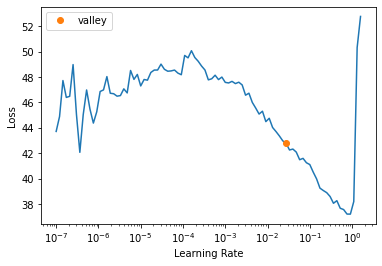

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.00
1    6.00       4.67
2    4.00       4.67
3    0.00       0.00
4   11.00       4.67
XGBoost RMSE:  2.678154


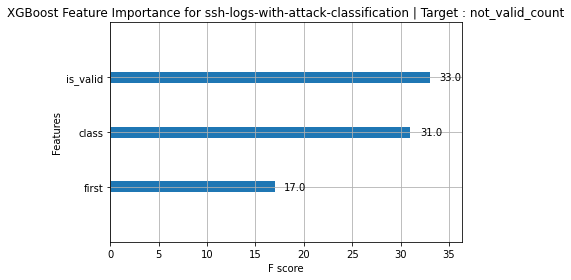

Target Variable: is_valid
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
13
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4152544788092024, 'Adjusted R-Squared': 0.3567799266901226, 'RMSE': 0.35160269012883716, 'Time taken': 0.019223451614379883}
{'Model': 'BaggingRegressor', 'R-Squared': 0.47829144540294777, 'Adjusted R-Squared': 0.42612058994324253, 'RMSE': 0.3321105839244967, 'Time taken': 0.02808403968811035}
{'Model': 'BayesianRidge', 'R-Squared': 0.4208071019124743, 'Adjusted R-Squared': 0.3628878121037217, 'RMSE': 0.3499293348087629, 'Time taken': 0.010986089706420898}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.47877439988945736, 'Adjusted R-Squared': 0.42665183987840305, 'RMSE': 0.3319568281232609, 'Time taken': 0.00971674919128418}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004957935310876405, 'Adjusted R-Squared': -0.10054537288419652, 'RMSE': 0.4599137255188574, 'Time taken': 0.008937597274780273}
{'Model': 'ElasticNet', 'R-Squared': -0.0004957935310876405, 'Adjusted R-Squared': -0.10054537288419652, 'RMSE': 0.4599137255188574, 'Time taken'

 17%|█▋        | 7/42 [00:00<00:00, 45.78it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.42085022614818124, 'Adjusted R-Squared': 0.3629352487629993, 'RMSE': 0.3499163074425195, 'Time taken': 0.06549477577209473}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.47877439988945736, 'Adjusted R-Squared': 0.42665183987840305, 'RMSE': 0.3319568281232609, 'Time taken': 0.01119375228881836}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.4787743998894576, 'Adjusted R-Squared': 0.42665183987840327, 'RMSE': 0.3319568281232608, 'Time taken': 0.10222625732421875}
{'Model': 'GammaRegressor', 'R-Squared': 0.32878133425746925, 'Adjusted R-Squared': 0.26165946768321613, 'RMSE': 0.3767044493386849, 'Time taken': 0.011723518371582031}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.14094826535507476, 'Adjusted R-Squared': 0.05504309189058221, 'RMSE': 0.42616560601094855, 'Time taken': 0.031090974807739258}


 29%|██▊       | 12/42 [00:00<00:01, 25.40it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.47656218908986103, 'Adjusted R-Squared': 0.42421840799884714, 'RMSE': 0.3326605358165275, 'Time taken': 0.12465572357177734}


 36%|███▌      | 15/42 [00:00<00:01, 23.58it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.42805621191418375, 'Adjusted R-Squared': 0.37086183310560206, 'RMSE': 0.3477326025138441, 'Time taken': 0.08957505226135254}
{'Model': 'HuberRegressor', 'R-Squared': -0.09258410530067929, 'Adjusted R-Squared': -0.2018425158307473, 'RMSE': 0.4806137331865738, 'Time taken': 0.043546438217163086}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.2094117647058822, 'Adjusted R-Squared': 0.13035294117647034, 'RMSE': 0.4088310863215482, 'Time taken': 0.012140035629272461}
{'Model': 'KernelRidge', 'R-Squared': -13.662776287104842, 'Adjusted R-Squared': -15.129053915815327, 'RMSE': 1.7606654475940526, 'Time taken': 0.030347347259521484}
{'Model': 'Lars', 'R-Squared': 0.42081570609541186, 'Adjusted R-Squared': 0.362897276704953, 'RMSE': 0.3499267356166769, 'Time taken': 0.04653120040893555}


 52%|█████▏    | 22/42 [00:00<00:00, 26.37it/s]

{'Model': 'LarsCV', 'R-Squared': 0.42081570609541186, 'Adjusted R-Squared': 0.362897276704953, 'RMSE': 0.3499267356166769, 'Time taken': 0.06814455986022949}
{'Model': 'Lasso', 'R-Squared': -0.0004957935310876405, 'Adjusted R-Squared': -0.10054537288419652, 'RMSE': 0.4599137255188574, 'Time taken': 0.011313915252685547}
{'Model': 'LassoCV', 'R-Squared': 0.42084803787480707, 'Adjusted R-Squared': 0.3629328416622877, 'RMSE': 0.34991696850797277, 'Time taken': 0.06192755699157715}
{'Model': 'LassoLars', 'R-Squared': -0.0004957935310876405, 'Adjusted R-Squared': -0.10054537288419652, 'RMSE': 0.4599137255188574, 'Time taken': 0.01046609878540039}
{'Model': 'LassoLarsCV', 'R-Squared': 0.42081570609541186, 'Adjusted R-Squared': 0.362897276704953, 'RMSE': 0.3499267356166769, 'Time taken': 0.019751310348510742}
{'Model': 'LassoLarsIC', 'R-Squared': 0.41863663086624203, 'Adjusted R-Squared': 0.3605002939528662, 'RMSE': 0.35058438537355824, 'Time taken': 0.012366294860839844}
{'Model': 'LinearReg

 74%|███████▍  | 31/42 [00:01<00:00, 24.55it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.4756381029048097, 'Adjusted R-Squared': 0.42320191319529055, 'RMSE': 0.33295404866874334, 'Time taken': 0.27221202850341797}
{'Model': 'NuSVR', 'R-Squared': 0.23906646525746822, 'Adjusted R-Squared': 0.16297311178321494, 'RMSE': 0.401090244730316, 'Time taken': 0.024276256561279297}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.19117845291962954, 'Adjusted R-Squared': 0.11029629821159237, 'RMSE': 0.4135186424316127, 'Time taken': 0.019914627075195312}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.42152022843199943, 'Adjusted R-Squared': 0.3636722512751993, 'RMSE': 0.3497138446422071, 'Time taken': 0.03190445899963379}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -2.5002738881977242, 'Adjusted R-Squared': -2.850301277017497, 'RMSE': 0.8602402347250221, 'Time taken': 0.020671367645263672}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3609845675155787, 'Adjusted R-Squared': 0.2970830242671365, 'RMSE': 0.36755675657501513, '

 81%|████████  | 34/42 [00:02<00:00,  8.94it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.4759140438506122, 'Adjusted R-Squared': 0.4235054482356734, 'RMSE': 0.3328664300355221, 'Time taken': 0.15981531143188477}
{'Model': 'Ridge', 'R-Squared': 0.42086043703300224, 'Adjusted R-Squared': 0.3629464807363024, 'RMSE': 0.3499132227733871, 'Time taken': 0.012834310531616211}
{'Model': 'RidgeCV', 'R-Squared': 0.4205938427310626, 'Adjusted R-Squared': 0.3626532270041688, 'RMSE': 0.34999375097797186, 'Time taken': 0.010512590408325195}
{'Model': 'SGDRegressor', 'R-Squared': 0.41733483842242636, 'Adjusted R-Squared': 0.3590683222646689, 'RMSE': 0.3509766812481316, 'Time taken': 0.010298013687133789}
{'Model': 'SVR', 'R-Squared': 0.3426641815556375, 'Adjusted R-Squared': 0.27693059971120115, 'RMSE': 0.3727883966234504, 'Time taken': 0.011543035507202148}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4208157060954121, 'Adjusted R-Squared': 0.3628972767049532, 'RMSE': 0.34992673561667686, 'Time taken': 0.010316610336303711}
{'Mo

100%|██████████| 42/42 [00:02<00:00, 15.11it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.47872064206410603, 'Adjusted R-Squared': 0.4265927062705166, 'RMSE': 0.33197397, 'Time taken': 0.4166595935821533}
{'Model': 'LGBMRegressor', 'R-Squared': 0.42805621191418375, 'Adjusted R-Squared': 0.37086183310560206, 'RMSE': 0.3477326025138441, 'Time taken': 0.03703713417053223}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: is_valid
is_valid
Target Standard Deviation: 0.4552898954390366
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.43       0.48  0.33        0.10
DecisionTreeRegressor                        0.43       0.48  0.33        0.01
ExtraTreeRegressor                           0.43       0.48  0.33        0.01
XGBRegressor                                 0.43       0.48  0.33        0.42
BaggingRegressor                             0.43 

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,10.915811,2.104451,1.450673,00:00
1,6.967992,0.830943,0.911561,00:00
2,5.565061,1.322047,1.149803,00:00


Better model found at epoch 0 with _rmse value: 1.4506727457046509.
Better model found at epoch 1 with _rmse value: 0.911560595035553.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.15
1       2       1.62
2       2       2.00
3       1       1.62
4       1       1.15
XGBoost RMSE:  0.33197397


<Figure size 432x288 with 0 Axes>

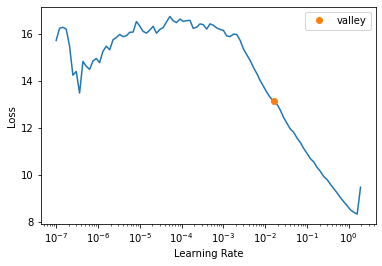

<Figure size 720x720 with 0 Axes>

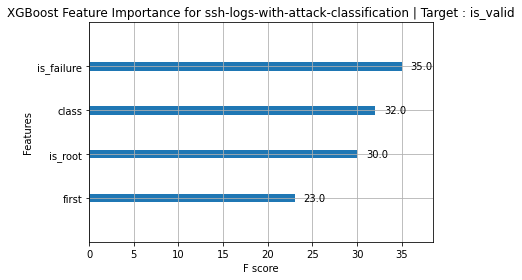

Target Variable: is_root
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
13
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5713686937966774, 'Adjusted R-Squared': 0.5285055631763451, 'RMSE': 0.22909706690770393, 'Time taken': 0.016303539276123047}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6250951604355066, 'Adjusted R-Squared': 0.5876046764790572, 'RMSE': 0.21425852386477762, 'Time taken': 0.028808116912841797}
{'Model': 'BayesianRidge', 'R-Squared': 0.5763406036170398, 'Adjusted R-Squared': 0.5339746639787437, 'RMSE': 0.22776448533866506, 'Time taken': 0.010689496994018555}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6222916666666667, 'Adjusted R-Squared': 0.5845208333333334, 'RMSE': 0.21505813167606566, 'Time taken': 0.010179996490478516}
{'Model': 'DummyRegressor', 'R-Squared': -0.0027687242798353218, 'Adjusted R-Squared': -0.10304559670781899, 'RMSE': 0.35041119710230967, 'Time taken': 0.009503602981567383}
{'Model': 'ElasticNet', 'R-Squared': -0.0027687242798353218, 'Adjusted R-Squared': -0.10304559670781899, 'RMSE': 0.35041119710230967, 'Time tak

 17%|█▋        | 7/42 [00:00<00:00, 46.51it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.5763405051378081, 'Adjusted R-Squared': 0.5339745556515889, 'RMSE': 0.22776451181048465, 'Time taken': 0.06403303146362305}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6222916666666667, 'Adjusted R-Squared': 0.5845208333333334, 'RMSE': 0.21505813167606566, 'Time taken': 0.011069774627685547}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6222916666666674, 'Adjusted R-Squared': 0.584520833333334, 'RMSE': 0.21505813167606547, 'Time taken': 0.10523104667663574}
{'Model': 'GammaRegressor', 'R-Squared': 0.41341030945526747, 'Adjusted R-Squared': 0.35475134040079415, 'RMSE': 0.2680061735227265, 'Time taken': 0.012023687362670898}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.03934557535665484, 'Adjusted R-Squared': -0.056719867107679844, 'RMSE': 0.3429739844914781, 'Time taken': 0.026684045791625977}


 29%|██▊       | 12/42 [00:00<00:01, 27.05it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6218006771381779, 'Adjusted R-Squared': 0.5839807448519956, 'RMSE': 0.21519786515380152, 'Time taken': 0.10399127006530762}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.362093986228913, 'Adjusted R-Squared': 0.2983033848518042, 'RMSE': 0.2794833455892601, 'Time taken': 0.16750383377075195}


 38%|███▊      | 16/42 [00:00<00:01, 21.42it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.4166666698675041, 'Adjusted R-Squared': 0.3583333368542545, 'RMSE': 0.26726124117917316, 'Time taken': 0.05292773246765137}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6208333333333333, 'Adjusted R-Squared': 0.5829166666666666, 'RMSE': 0.2154729018428337, 'Time taken': 0.011253595352172852}
{'Model': 'KernelRidge', 'R-Squared': -10.527262867043635, 'Adjusted R-Squared': -11.679989153748, 'RMSE': 1.1880663178275712, 'Time taken': 0.015050172805786133}
{'Model': 'Lars', 'R-Squared': 0.5762896939105173, 'Adjusted R-Squared': 0.533918663301569, 'RMSE': 0.227778169768751, 'Time taken': 0.020863056182861328}
{'Model': 'LarsCV', 'R-Squared': 0.5762896939105173, 'Adjusted R-Squared': 0.533918663301569, 'RMSE': 0.227778169768751, 'Time taken': 0.03717541694641113}
{'Model': 'Lasso', 'R-Squared': -0.0027687242798353218, 'Adjusted R-Squared': -0.10304559670781899, 'RMSE': 0.35041119710230967, 'Time taken': 0.019235849380493164}


 48%|████▊     | 20/42 [00:00<00:00, 22.27it/s]

{'Model': 'LassoCV', 'R-Squared': 0.5763278986540221, 'Adjusted R-Squared': 0.5339606885194244, 'RMSE': 0.22776790048499862, 'Time taken': 0.08581042289733887}
{'Model': 'LassoLars', 'R-Squared': -0.0027687242798353218, 'Adjusted R-Squared': -0.10304559670781899, 'RMSE': 0.35041119710230967, 'Time taken': 0.01102304458618164}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5762896939105173, 'Adjusted R-Squared': 0.533918663301569, 'RMSE': 0.227778169768751, 'Time taken': 0.018129348754882812}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5762896939105173, 'Adjusted R-Squared': 0.533918663301569, 'RMSE': 0.227778169768751, 'Time taken': 0.011312007904052734}
{'Model': 'LinearRegression', 'R-Squared': 0.5762896939105175, 'Adjusted R-Squared': 0.5339186633015693, 'RMSE': 0.22777816976875098, 'Time taken': 0.00928044319152832}
{'Model': 'LinearSVR', 'R-Squared': 0.41666666666679675, 'Adjusted R-Squared': 0.3583333333334764, 'RMSE': 0.2672612419123946, 'Time taken': 0.009204864501953125}


 74%|███████▍  | 31/42 [00:01<00:00, 26.44it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.592644193075598, 'Adjusted R-Squared': 0.5519086123831578, 'RMSE': 0.22333898649519812, 'Time taken': 0.210252046585083}
{'Model': 'NuSVR', 'R-Squared': 0.34046991157839424, 'Adjusted R-Squared': 0.27451690273623364, 'RMSE': 0.28418090424470727, 'Time taken': 0.0242769718170166}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.46118802956553095, 'Adjusted R-Squared': 0.407306832522084, 'RMSE': 0.2568598372100388, 'Time taken': 0.020930767059326172}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5762896939105173, 'Adjusted R-Squared': 0.533918663301569, 'RMSE': 0.22777816976875104, 'Time taken': 0.03191184997558594}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.03811937179225011, 'Adjusted R-Squared': -0.058068691028524855, 'RMSE': 0.34319280501373256, 'Time taken': 0.02031850814819336}
{'Model': 'PoissonRegressor', 'R-Squared': 0.46685743728037776, 'Adjusted R-Squared': 0.4135431810084155, 'RMSE': 0.2555049173342747, 'Time

 81%|████████  | 34/42 [00:02<00:00, 11.15it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6234926077721595, 'Adjusted R-Squared': 0.5858418685493755, 'RMSE': 0.2147159658411142, 'Time taken': 0.16288542747497559}
{'Model': 'Ridge', 'R-Squared': 0.5763708335368125, 'Adjusted R-Squared': 0.5340079168904937, 'RMSE': 0.22775635920596743, 'Time taken': 0.012374639511108398}
{'Model': 'RidgeCV', 'R-Squared': 0.5759489058591809, 'Adjusted R-Squared': 0.533543796445099, 'RMSE': 0.2278697517713687, 'Time taken': 0.012941598892211914}
{'Model': 'SGDRegressor', 'R-Squared': 0.5713668742609811, 'Adjusted R-Squared': 0.5285035616870792, 'RMSE': 0.22909755316459038, 'Time taken': 0.011421680450439453}
{'Model': 'SVR', 'R-Squared': 0.38635688741543717, 'Adjusted R-Squared': 0.32499257615698085, 'RMSE': 0.2741167141374971, 'Time taken': 0.010984420776367188}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5762896939105175, 'Adjusted R-Squared': 0.5339186633015693, 'RMSE': 0.22777816976875098, 'Time taken': 0.010210752487182617}
{'Mod

100%|██████████| 42/42 [00:02<00:00, 16.70it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6222136106711842, 'Adjusted R-Squared': 0.5844349717383026, 'RMSE': 0.21508035, 'Time taken': 0.36837220191955566}
{'Model': 'LGBMRegressor', 'R-Squared': 0.18683373029119743, 'Adjusted R-Squared': 0.10551710332031705, 'RMSE': 0.3155493304767785, 'Time taken': 0.04438352584838867}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: is_root
is_root
Target Standard Deviation: 0.33008790449114916
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BaggingRegressor                             0.59       0.63  0.21        0.03
RandomForestRegressor                        0.59       0.62  0.21        0.16
ExtraTreesRegressor                          0.58       0.62  0.22        0.11
DecisionTreeRegressor                        0.58       0.62  0.22        0.01
ExtraTreeRegressor                           0.58  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,9.296498,1.574014,1.254597,00:00
1,6.412367,1.019993,1.009947,00:00
2,5.141343,0.292216,0.540570,00:00
3,5.455406,0.158035,0.397536,00:00
4,6.152409,0.235185,0.484958,00:00


Better model found at epoch 0 with _rmse value: 1.2545973062515259.
Better model found at epoch 1 with _rmse value: 1.0099469423294067.
Better model found at epoch 2 with _rmse value: 0.5405696630477905.
Better model found at epoch 3 with _rmse value: 0.3975355625152588.
No improvement since epoch 3: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.17
4       1       1.00
XGBoost RMSE:  0.21508035


<Figure size 432x288 with 0 Axes>

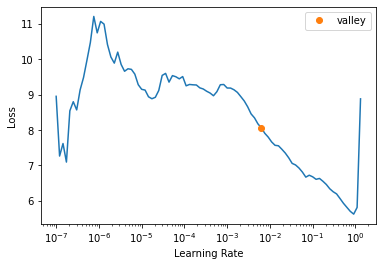

<Figure size 720x720 with 0 Axes>

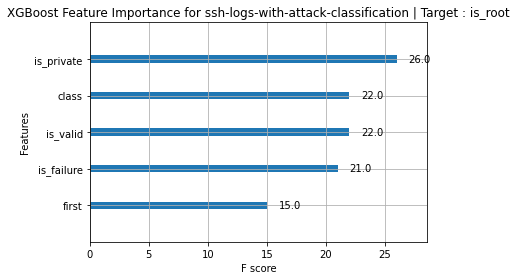

Target Variable: is_failure
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
13
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3623767404870787, 'Adjusted R-Squared': 0.2986144145357865, 'RMSE': 0.36715615467905144, 'Time taken': 0.018673419952392578}
{'Model': 'BaggingRegressor', 'R-Squared': 0.3863067274111808, 'Adjusted R-Squared': 0.32493740015229877, 'RMSE': 0.3602005888369219, 'Time taken': 0.031199932098388672}
{'Model': 'BayesianRidge', 'R-Squared': 0.33750674859942176, 'Adjusted R-Squared': 0.2712574234593639, 'RMSE': 0.3742479813648575, 'Time taken': 0.013393878936767578}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.38674587000502914, 'Adjusted R-Squared': 0.325420457005532, 'RMSE': 0.3600716907901857, 'Time taken': 0.011897563934326172}
{'Model': 'DummyRegressor', 'R-Squared': -0.003712537474628963, 'Adjusted R-Squared': -0.10408379122209199, 'RMSE': 0.4606524779781089, 'Time taken': 0.012171268463134766}
{'Model': 'ElasticNet', 'R-Squared': -0.003712537474628963, 'Adjusted R-Squared': -0.10408379122209199, 'RMSE': 0.4606524779781089, 'Time taken': 

 17%|█▋        | 7/42 [00:00<00:00, 39.48it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3291964433859905, 'Adjusted R-Squared': 0.2621160877245895, 'RMSE': 0.37658794658922756, 'Time taken': 0.07895493507385254}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.38674587000502914, 'Adjusted R-Squared': 0.325420457005532, 'RMSE': 0.3600716907901857, 'Time taken': 0.013008594512939453}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.3867458700050297, 'Adjusted R-Squared': 0.32542045700553257, 'RMSE': 0.3600716907901855, 'Time taken': 0.12942171096801758}
{'Model': 'GammaRegressor', 'R-Squared': 0.23699392439781652, 'Adjusted R-Squared': 0.16069331683759813, 'RMSE': 0.4016360944132613, 'Time taken': 0.017538785934448242}


 26%|██▌       | 11/42 [00:00<00:01, 26.24it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.386736956744381, 'Adjusted R-Squared': 0.32541065241881906, 'RMSE': 0.360074307487745, 'Time taken': 0.05292510986328125}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.3866316425057369, 'Adjusted R-Squared': 0.3252948067563105, 'RMSE': 0.36010522352294877, 'Time taken': 0.12048602104187012}


 43%|████▎     | 18/42 [00:01<00:02, 11.85it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.3525942186387522, 'Adjusted R-Squared': 0.2878536405026273, 'RMSE': 0.3699619193390093, 'Time taken': 0.647899866104126}
{'Model': 'HuberRegressor', 'R-Squared': -0.3308402616848234, 'Adjusted R-Squared': -0.46392428785330586, 'RMSE': 0.5304344260361601, 'Time taken': 0.019427061080932617}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.32090497737556545, 'Adjusted R-Squared': 0.2529954751131219, 'RMSE': 0.37890820599642416, 'Time taken': 0.011211633682250977}
{'Model': 'KernelRidge', 'R-Squared': -13.249952840614519, 'Adjusted R-Squared': -14.674948124675971, 'RMSE': 1.7357031463971833, 'Time taken': 0.033113956451416016}
{'Model': 'Lars', 'R-Squared': 0.3442266596820064, 'Adjusted R-Squared': 0.27864932565020695, 'RMSE': 0.37234507660032834, 'Time taken': 0.04379582405090332}
{'Model': 'LarsCV', 'R-Squared': 0.32601233503924065, 'Adjusted R-Squared': 0.25861356854316464, 'RMSE': 0.37748066491105364, 'Time taken': 0.07273578643

 52%|█████▏    | 22/42 [00:01<00:01, 15.54it/s]

{'Model': 'LassoCV', 'R-Squared': 0.3304044630980515, 'Adjusted R-Squared': 0.2634449094078566, 'RMSE': 0.3762487037090321, 'Time taken': 0.0656120777130127}
{'Model': 'LassoLars', 'R-Squared': -0.003712537474628963, 'Adjusted R-Squared': -0.10408379122209199, 'RMSE': 0.4606524779781089, 'Time taken': 0.011628389358520508}
{'Model': 'LassoLarsCV', 'R-Squared': 0.32601233503924065, 'Adjusted R-Squared': 0.25861356854316464, 'RMSE': 0.37748066491105364, 'Time taken': 0.01866769790649414}
{'Model': 'LassoLarsIC', 'R-Squared': 0.32011622267029793, 'Adjusted R-Squared': 0.25212784493732765, 'RMSE': 0.379128189127799, 'Time taken': 0.014378070831298828}
{'Model': 'LinearRegression', 'R-Squared': 0.3442266596820064, 'Adjusted R-Squared': 0.27864932565020695, 'RMSE': 0.37234507660032834, 'Time taken': 0.010078668594360352}
{'Model': 'LinearSVR', 'R-Squared': -0.4358974358153096, 'Adjusted R-Squared': -0.5794871793968406, 'RMSE': 0.5509731650035833, 'Time taken': 0.009979724884033203}


 69%|██████▉   | 29/42 [00:01<00:00, 14.80it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.36070262417936605, 'Adjusted R-Squared': 0.2967728865973026, 'RMSE': 0.3676378334509768, 'Time taken': 0.39897799491882324}
{'Model': 'NuSVR', 'R-Squared': -0.18250377073906465, 'Adjusted R-Squared': -0.30075414781297116, 'RMSE': 0.49999999999999994, 'Time taken': 0.03747844696044922}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.18304823914942647, 'Adjusted R-Squared': 0.10135306306436909, 'RMSE': 0.41559177496627697, 'Time taken': 0.0290679931640625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3294113766215947, 'Adjusted R-Squared': 0.26235251428375406, 'RMSE': 0.37652761018394115, 'Time taken': 0.03286600112915039}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.4787322118467632, 'Adjusted R-Squared': -1.7266054330314398, 'RMSE': 0.7239082773545625, 'Time taken': 0.011617898941040039}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2705394557634251, 'Adjusted R-Squared': 0.19759340133976755, 'RMSE': 0.3927079021840161

 76%|███████▌  | 32/42 [00:02<00:01,  7.98it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.43589743590742436, 'Adjusted R-Squared': -0.5794871794981669, 'RMSE': 0.5509731650212562, 'Time taken': 0.8046753406524658}
{'Model': 'RANSACRegressor', 'R-Squared': -0.4358974358974359, 'Adjusted R-Squared': -0.5794871794871796, 'RMSE': 0.5509731650193397, 'Time taken': 0.10152006149291992}


 81%|████████  | 34/42 [00:03<00:01,  7.95it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.38207736407040427, 'Adjusted R-Squared': 0.32028510047744463, 'RMSE': 0.3614396471081957, 'Time taken': 0.1465892791748047}
{'Model': 'Ridge', 'R-Squared': 0.3437425268807889, 'Adjusted R-Squared': 0.2781167795688677, 'RMSE': 0.3724824954274821, 'Time taken': 0.012647151947021484}
{'Model': 'RidgeCV', 'R-Squared': 0.3437425268808034, 'Adjusted R-Squared': 0.2781167795688837, 'RMSE': 0.37248249542747797, 'Time taken': 0.010859489440917969}
{'Model': 'SGDRegressor', 'R-Squared': 0.34164561189744325, 'Adjusted R-Squared': 0.27581017308718747, 'RMSE': 0.3730771105185302, 'Time taken': 0.009773731231689453}
{'Model': 'SVR', 'R-Squared': 0.21689583258047385, 'Adjusted R-Squared': 0.13858541583852113, 'RMSE': 0.4068913943839403, 'Time taken': 0.012244224548339844}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3442266596820064, 'Adjusted R-Squared': 0.27864932565020695, 'RMSE': 0.37234507660032834, 'Time taken': 0.010196447372436523}
{

100%|██████████| 42/42 [00:03<00:00, 11.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.3866798516812049, 'Adjusted R-Squared': 0.32534783684932533, 'RMSE': 0.3600911, 'Time taken': 0.3614466190338135}
{'Model': 'LGBMRegressor', 'R-Squared': 0.3525942186387522, 'Adjusted R-Squared': 0.2878536405026273, 'RMSE': 0.3699619193390093, 'Time taken': 0.045000314712524414}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: is_failure
is_failure
Target Standard Deviation: 0.446793790643989
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.33       0.39  0.36        0.13
DecisionTreeRegressor                        0.33       0.39  0.36        0.01
ExtraTreeRegressor                           0.33       0.39  0.36        0.01
GaussianProcessRegressor                     0.33       0.39  0.36        0.05
XGBRegressor                                 0.33

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,27.515409,2.019592,1.421123,00:00
1,17.711216,0.329745,0.574234,00:00
2,15.869266,0.683411,0.826687,00:00


Better model found at epoch 0 with _rmse value: 1.4211233854293823.
Better model found at epoch 1 with _rmse value: 0.5742338299751282.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       1       1.49
2       1       1.49
3       2       1.49
4       2       2.00
XGBoost RMSE:  0.3600911


<Figure size 432x288 with 0 Axes>

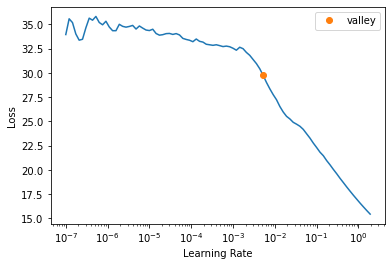

<Figure size 720x720 with 0 Axes>

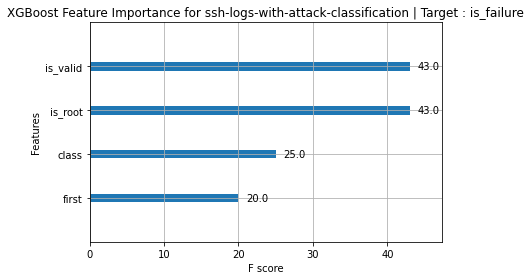

Target Variable: is_private
CATS=====================
['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
CONTS=====================
['user', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
13
Could not convert user to float.
Looping through continuous variables to find breakpoint
Error with  user
Continuous variables that made the cut : ['not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'td', 'ts']
Categorical variables that made the cut : ['is_private', 'is_failure', 'is_root', 'is_valid', 'first', 'class']
Tabular Object size: 281


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.26823639482301564, 'Adjusted R-Squared': 0.19506003430531715, 'RMSE': 0.19261758701844325, 'Time taken': 0.018387794494628906}
{'Model': 'BaggingRegressor', 'R-Squared': 0.32063894095750145, 'Adjusted R-Squared': 0.25270283505325153, 'RMSE': 0.18559268717223304, 'Time taken': 0.02704000473022461}
{'Model': 'BayesianRidge', 'R-Squared': 0.33351287220145664, 'Adjusted R-Squared': 0.26686415942160224, 'RMSE': 0.1838257803267676, 'Time taken': 0.010411262512207031}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.31355092520401273, 'Adjusted R-Squared': 0.2449060177244139, 'RMSE': 0.18655835221055084, 'Time taken': 0.009913444519042969}
{'Model': 'DummyRegressor', 'R-Squared': -0.00043245593601981547, 'Adjusted R-Squared': -0.10047570152962182, 'RMSE': 0.2252186865917734, 'Time taken': 0.00948953628540039}
{'Model': 'ElasticNet', 'R-Squared': -0.00043245593601981547, 'Adjusted R-Squared': -0.10047570152962182, 'RMSE': 0.2252186865917734, 'Time

 17%|█▋        | 7/42 [00:00<00:00, 45.56it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.33644543479640165, 'Adjusted R-Squared': 0.27008997827604175, 'RMSE': 0.18342091511211336, 'Time taken': 0.06709027290344238}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.31355092520401273, 'Adjusted R-Squared': 0.2449060177244139, 'RMSE': 0.18655835221055084, 'Time taken': 0.011575937271118164}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.3135509252040123, 'Adjusted R-Squared': 0.24490601772441345, 'RMSE': 0.1865583522105509, 'Time taken': 0.10231494903564453}
{'Model': 'GammaRegressor', 'R-Squared': 0.2702177736842425, 'Adjusted R-Squared': 0.19723955105266666, 'RMSE': 0.19235663723360474, 'Time taken': 0.01254725456237793}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.8479775273460031, 'Adjusted R-Squared': -1.0327752800806036, 'RMSE': 0.3060968624038378, 'Time taken': 0.03731036186218262}


 29%|██▊       | 12/42 [00:00<00:01, 24.84it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.31355152708186496, 'Adjusted R-Squared': 0.24490667979005143, 'RMSE': 0.18655827042344594, 'Time taken': 0.12573981285095215}


 36%|███▌      | 15/42 [00:00<00:01, 22.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.33495371319555123, 'Adjusted R-Squared': 0.2684490845151063, 'RMSE': 0.18362697151828095, 'Time taken': 0.09177732467651367}
{'Model': 'HuberRegressor', 'R-Squared': -0.05660376687915081, 'Adjusted R-Squared': -0.16226414356706598, 'RMSE': 0.23145502420867112, 'Time taken': 0.059374094009399414}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.3237735849056603, 'Adjusted R-Squared': 0.25615094339622635, 'RMSE': 0.1851640199545103, 'Time taken': 0.010196447372436523}
{'Model': 'KernelRidge', 'R-Squared': -74.83955247405397, 'Adjusted R-Squared': -82.42350772145937, 'RMSE': 1.9609134074155852, 'Time taken': 0.03198504447937012}
{'Model': 'Lars', 'R-Squared': 0.33270759771329217, 'Adjusted R-Squared': 0.2659783574846213, 'RMSE': 0.1839367993683101, 'Time taken': 0.04256772994995117}


 55%|█████▍    | 23/42 [00:00<00:00, 27.52it/s]

{'Model': 'LarsCV', 'R-Squared': 0.3366706964617393, 'Adjusted R-Squared': 0.27033776610791316, 'RMSE': 0.1833897788573404, 'Time taken': 0.07699394226074219}
{'Model': 'Lasso', 'R-Squared': -0.00043245593601981547, 'Adjusted R-Squared': -0.10047570152962182, 'RMSE': 0.2252186865917734, 'Time taken': 0.010303020477294922}
{'Model': 'LassoCV', 'R-Squared': 0.3373104724170357, 'Adjusted R-Squared': 0.27104151965873924, 'RMSE': 0.18330131851452072, 'Time taken': 0.0595245361328125}
{'Model': 'LassoLars', 'R-Squared': -0.00043245593601981547, 'Adjusted R-Squared': -0.10047570152962182, 'RMSE': 0.2252186865917734, 'Time taken': 0.010089874267578125}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3366706964617393, 'Adjusted R-Squared': 0.27033776610791316, 'RMSE': 0.1833897788573404, 'Time taken': 0.018114566802978516}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3391740375952985, 'Adjusted R-Squared': 0.2730914413548283, 'RMSE': 0.18304340403911903, 'Time taken': 0.011399507522583008}
{'Model': 'Linear

 64%|██████▍   | 27/42 [00:01<00:00, 19.83it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.27261090082297634, 'Adjusted R-Squared': 0.19987199090527397, 'RMSE': 0.19204098697657515, 'Time taken': 0.272841215133667}
{'Model': 'NuSVR', 'R-Squared': -0.05952018316846863, 'Adjusted R-Squared': -0.1654722014853156, 'RMSE': 0.23177423282411577, 'Time taken': 0.02368474006652832}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.33872416891284807, 'Adjusted R-Squared': 0.2725965858041328, 'RMSE': 0.18310569841761595, 'Time taken': 0.020480871200561523}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.33872416891284807, 'Adjusted R-Squared': 0.2725965858041328, 'RMSE': 0.18310569841761595, 'Time taken': 0.031610965728759766}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.1015846070112032, 'Adjusted R-Squared': -0.21174306771232354, 'RMSE': 0.23633033168502998, 'Time taken': 0.02053236961364746}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3037462672360375, 'Adjusted R-Squared': 0.2341208939596412, 'RMSE': 0.187885949303352

 76%|███████▌  | 32/42 [00:01<00:00, 11.51it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.05660377351922086, 'Adjusted R-Squared': -0.1622641508711431, 'RMSE': 0.23145502493594355, 'Time taken': 0.6552250385284424}
{'Model': 'RANSACRegressor', 'R-Squared': -0.05660377358490565, 'Adjusted R-Squared': -0.1622641509433964, 'RMSE': 0.23145502494313785, 'Time taken': 0.05813097953796387}


 81%|████████  | 34/42 [00:02<00:00, 10.87it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.3052373270279898, 'Adjusted R-Squared': 0.23576105973078865, 'RMSE': 0.18768465822207064, 'Time taken': 0.17205095291137695}
{'Model': 'Ridge', 'R-Squared': 0.3328591210165056, 'Adjusted R-Squared': 0.26614503311815607, 'RMSE': 0.1839159147503598, 'Time taken': 0.011603832244873047}
{'Model': 'RidgeCV', 'R-Squared': 0.33352357369591856, 'Adjusted R-Squared': 0.26687593106551033, 'RMSE': 0.18382430451546924, 'Time taken': 0.009893178939819336}
{'Model': 'SGDRegressor', 'R-Squared': 0.3302801881214483, 'Adjusted R-Squared': 0.26330820693359314, 'RMSE': 0.1842710491194623, 'Time taken': 0.010038375854492188}
{'Model': 'SVR', 'R-Squared': -0.04874445394271221, 'Adjusted R-Squared': -0.15361889933698358, 'RMSE': 0.23059260403577234, 'Time taken': 0.010288476943969727}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3327075977132923, 'Adjusted R-Squared': 0.2659783574846214, 'RMSE': 0.1839367993683101, 'Time taken': 0.00985240936279296

100%|██████████| 42/42 [00:02<00:00, 15.66it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.3138230350606943, 'Adjusted R-Squared': 0.24520533856676363, 'RMSE': 0.18652137, 'Time taken': 0.3769795894622803}
{'Model': 'LGBMRegressor', 'R-Squared': 0.33464986682927256, 'Adjusted R-Squared': 0.26811485351219977, 'RMSE': 0.18366891447606712, 'Time taken': 0.06438684463500977}
Project: ssh-logs-with-attack-classification
ssh-logs-with-attack-classification
Target: is_private
is_private
Target Standard Deviation: 0.2156357239237014
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                  0.27       0.34  0.18        0.01
OrthogonalMatchingPursuitCV                  0.27       0.34  0.18        0.03
OrthogonalMatchingPursuit                    0.27       0.34  0.18        0.02
LassoCV                                      0.27       0.34  0.18        0.06
LassoLarsCV                                  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,6.976652,3.353410,1.831232,00:00
1,7.028372,4.010138,2.002533,00:00


Better model found at epoch 0 with _rmse value: 1.8312318325042725.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       2       2.00
3       2       2.00
4       2       2.00
XGBoost RMSE:  0.18652137


<Figure size 432x288 with 0 Axes>

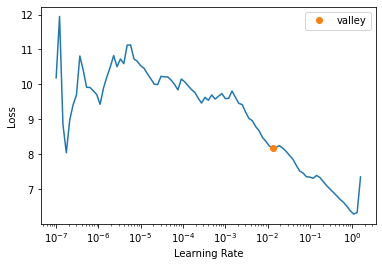

<Figure size 720x720 with 0 Axes>

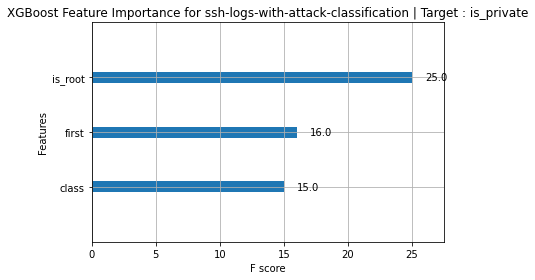

<Figure size 432x288 with 0 Axes>

In [18]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

      feature  importance
0  is_private       49.00
1  is_failure       52.00
2     is_root       35.00
3    is_valid       73.00
4       first      119.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

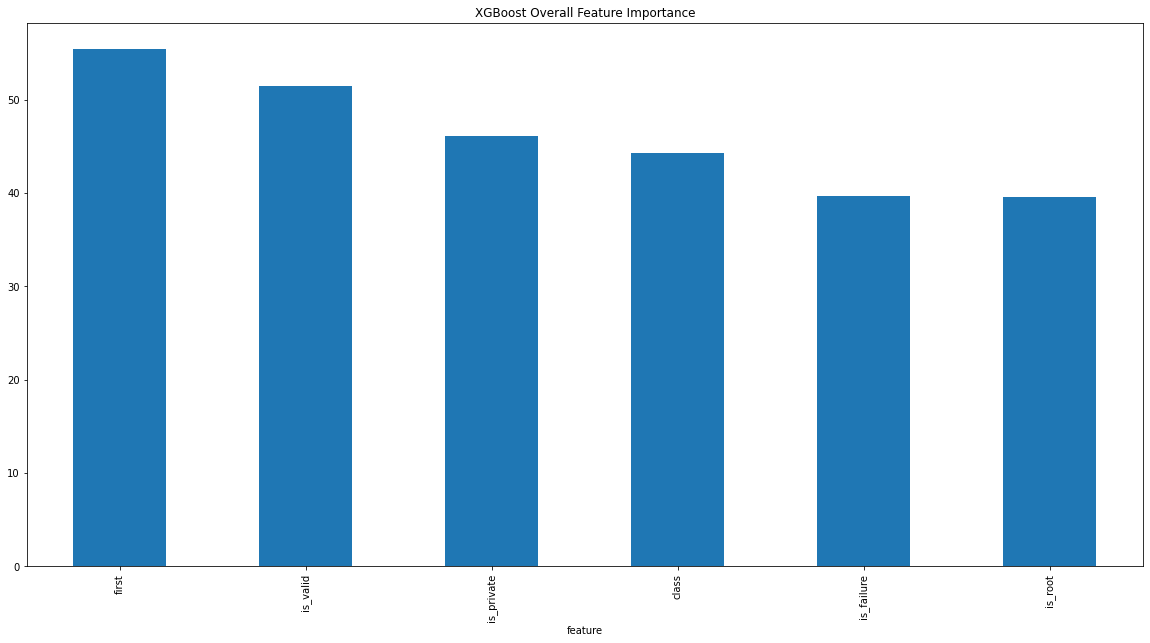

In [19]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [20]:
df.isna().sum()

user               0
is_private         0
is_failure         0
is_root            0
is_valid           0
not_valid_count    0
ip_failure         0
ip_success         0
no_failure         0
first              0
td                 0
ts                 0
class              0
dtype: int64

# **To Be Continued...**